# ANALYSIS OF NEURAL-DATA - CHARACTERISTIC TIMES DISTRIBUTIONS

#### Libraries, Data, Hyperparameters, Functions

In [1]:
#Libraries
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from scipy.ndimage import gaussian_filter1d
from scipy.optimize import curve_fit
from scipy import stats
from scipy.signal import welch

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7908709581f0>>
Traceback (most recent call last):
  File "/home/zenn/anaconda3/envs/glv/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


In [ ]:
#settings for plots

#tableau for plots
plt.style.use('tableau-colorblind10')

plt.rcParams["figure.autolayout"] = True

plt.rcParams['font.size'] = 16        # Default font size for text
plt.rcParams['axes.titlesize'] = 16   # Font size for axes titles
plt.rcParams['axes.labelsize'] = 16   # Font size for x and y labels
plt.rcParams['xtick.labelsize'] = 16  # Font size for x tick labels
plt.rcParams['ytick.labelsize'] = 16  # Font size for y tick labels

In [ ]:
#path to data
folder_traces = 'data/traces/'      
folder_stimuli = 'data/stimuli/'    

#listing the files in the folders
files_traces = os.listdir(folder_traces)
files_stimuli = os.listdir(folder_stimuli)

In [ ]:
#zipping together the correspondent traces and stimuli
zipped_file_list = []

for f in files_stimuli:
    #extracting the stimuli pattern
    pattern = f.split('.npy')[0]
    #finding the correpsponding trace
    for t in files_traces:
        if pattern == t.split('.npz')[0].split('ok')[1]:
            zipped_file_list.append((t,f))
            break

In [ ]:
#Hyperparameters of experimental data
f_sam = 30 #Hz   #sampling frequence
dt = 1/f_sam*10**(3) #ms   #sampling interval in ms

#number of fields 
N_fields = len(zipped_file_list)
#number of stimuli
N_stimuli = 10

In [ ]:
# function to plot the traces
def plot_trace(zscored_full, zscored_only_rec, reconstructed, stimuli_idx, n_list, filename, SAVE=False, folder_to_save='results/traces/'):   
    
    """
    Plot the traces of z-scored data and reconstructed data.

    Parameters:
    - zscored_full (ndarray): The z-scored full data.
    - zscored_only_rec (ndarray): The z-scored data with only reconstructed values.
    - reconstructed (ndarray): The reconstructed data.
    - stimuli_idx (list): The indices of the stimuli.
    - n_list (list): The list of indices to plot.
    - filename (str): The name of the file.
    - SAVE (bool): Whether to save the plot or not. Default is False.
    - folder_to_save (str): The folder path to save the plot. Default is 'results/tracce/'.

    Returns:
    None
    """

    for n in n_list:
        fig, ax = plt.subplots(2, 1, figsize=(15, 10))

        ax[0].plot(np.arange(len(zscored_full[n, :])) / f_sam, zscored_full[n, :], color='blue', alpha=0.6)
        ax[1].plot(np.arange(len(zscored_only_rec[n, :])) / f_sam, zscored_only_rec[n, :], color='blue', alpha=0.6)
        ax[1].plot(np.arange(len(zscored_only_rec[n, :])) / f_sam, reconstructed[n, :], label='Reconstructed Trace', color='red')

        ax[0].axvline(stimuli_idx[0] / f_sam, 0, 1, linestyle='--', color='k', label='Stimuli')
        for st in stimuli_idx[1:]:
            ax[0].axvline(st / f_sam, 0, 1, linestyle='--', color='k')

        ax[0].set_xlabel('Time [s]')
        ax[0].set_ylabel('Z-score')
        ax[0].legend()

        ax[1].set_xlabel('Time [s]')
        ax[1].set_ylabel('Z-score')
        ax[1].legend()

        # fig.suptitle('Traces for ' + filename.split('.npz')[0] + '_trace_' + str(n))

        if SAVE:
            plt.savefig(folder_to_save + filename.split('.npz')[0] + '_traccia_' + str(n) + '.png', pad_inches=0.1,
                        bbox_inches='tight')
            plt.close()

## Looking at the data

In [11]:
#info on data
counter_traces = 0
average_duration = 0

for files in zipped_file_list:
    data = np.load(folder_traces+files[0])
    counter_traces = counter_traces + data['zscored_full'].shape[0]
    average_duration = average_duration + data['zscored_full'].shape[1]

average_duration = average_duration/N_fields/f_sam

In [12]:
print('--------- Info on data: --------------')
print('Number of fields:', N_fields)
print('Total number of traces:', counter_traces)
print('Average duration of traces [seconds]:', int(average_duration))
print('--------------------------------------')

--------- Info on data: --------------
Number of fields: 8
Total number of traces: 568
Average duration of traces [seconds]: 1500
--------------------------------------


## Plot of traces

#### Example of trace

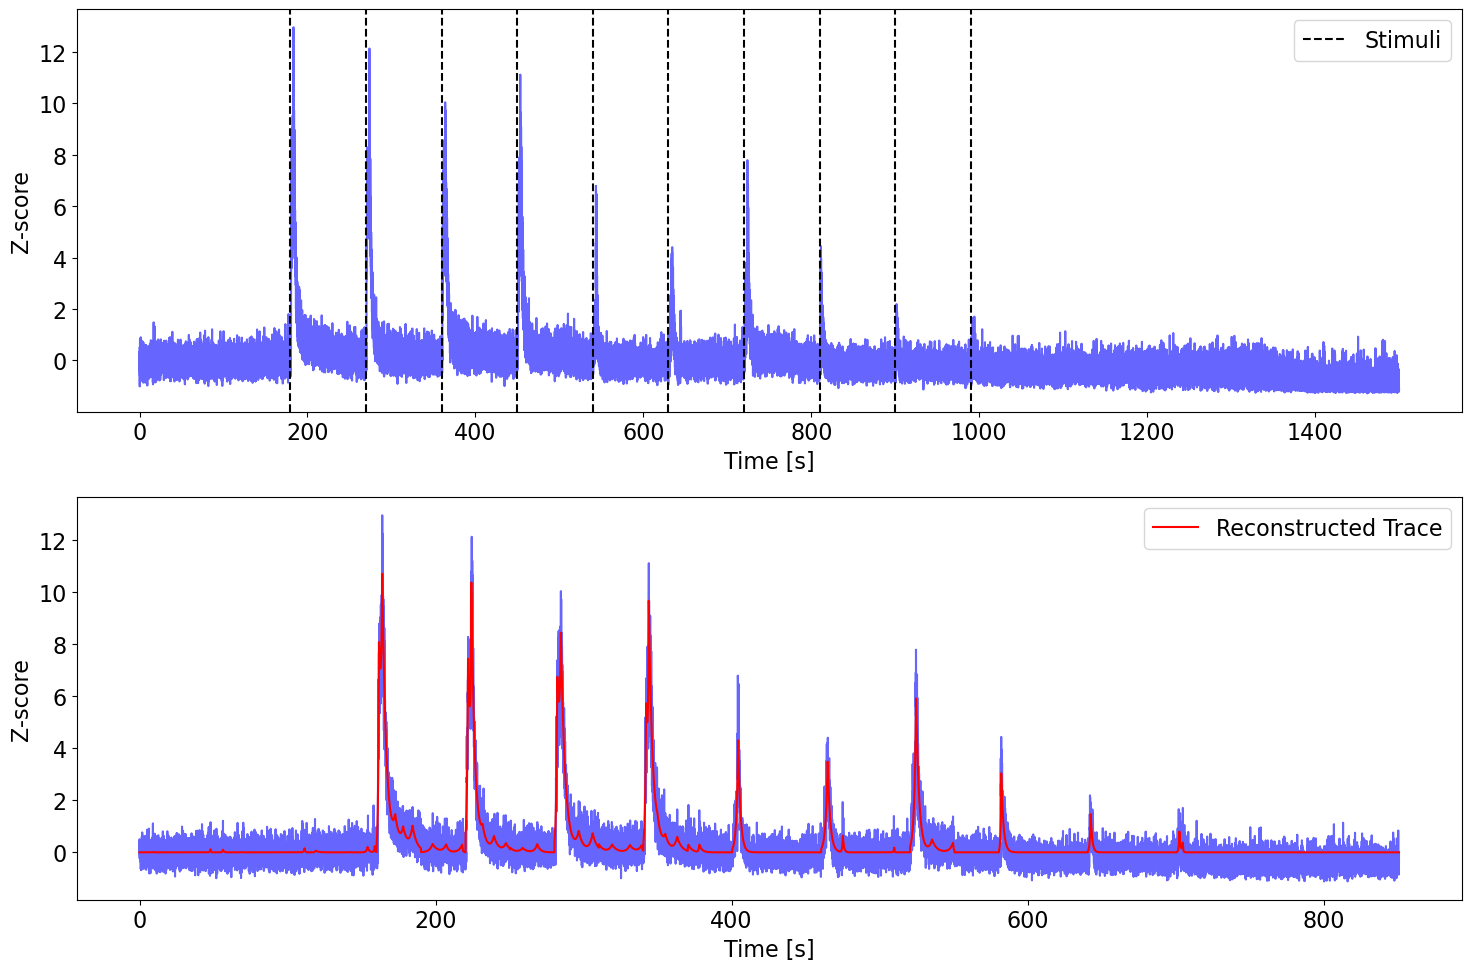

In [32]:
#sampling a random file and trace
n_file = np.random.randint(0, N_fields)
n_trace = np.random.randint(0, np.load(folder_traces+zipped_file_list[n_file][0])['filtered_snr'].shape[0])

#loading the data
data = np.load(folder_traces+zipped_file_list[n_file][0]) #traces
stimuli = np.load(folder_stimuli+zipped_file_list[n_file][1]) #stimuli

#selecting the index of stimuli
stimuli_idx = stimuli[:, 1]

#plot
plot_trace(data['zscored_full'], data['zscored_only_rec'], data['reconstructed'], stimuli_idx, [n_trace], zipped_file_list[n_file][0], SAVE = False, folder_to_save = 'results/main_results/')

#### Saving plot of some examples of traces for each field

In [35]:
#number of traces to plot
N_traces_to_plot = 5

for files in zipped_file_list:  #loop over all the fields
    data = np.load(folder_traces+files[0]) #traces
    stimuli = np.load(folder_stimuli+files[1]) #stimuli

    #selecting the index of stimuli
    stimuli_idx = stimuli[:, 1]

    #randomly selecting 5 traces
    n_samples = np.random.randint(0, data['filtered_snr'].shape[0], N_traces_to_plot)

    #saving the plot
    plot_trace(data['zscored_full'], data['zscored_only_rec'], data['reconstructed'], stimuli_idx, n_samples, files[0], SAVE = True)

## Ordering traces by Signal to Noise Ratio, save data and SNR plots, plot SNR example

In [36]:
#path to store sorted traces
path_to_sorted = 'data/sorted_traces/'   

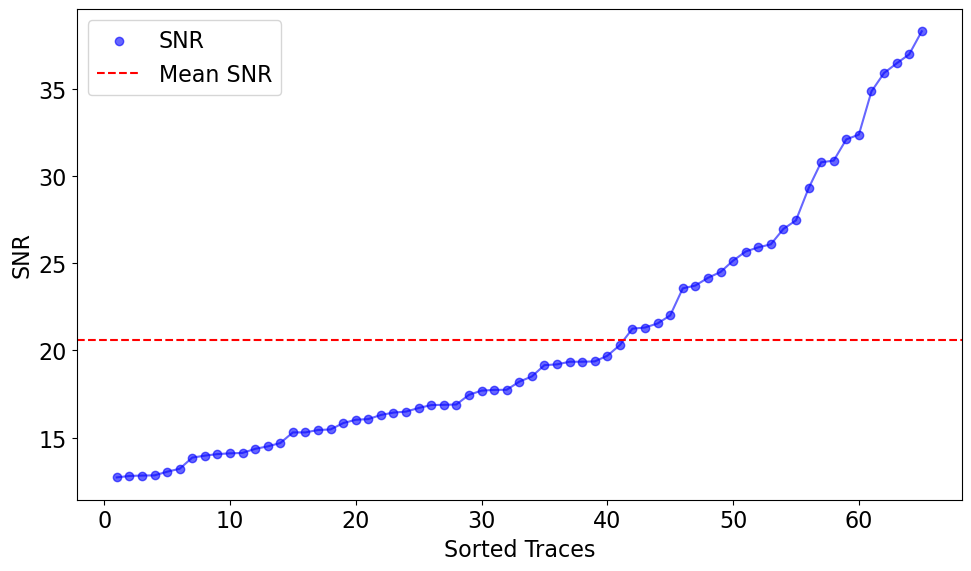

In [38]:
#sampling a random field to show the SNR
sample_file_idx = np.random.randint(0, N_fields)

for files in zipped_file_list:

    #loading data
    data = np.load(folder_traces+files[0]) #traces
    stimuli = np.load(folder_stimuli+files[1]) #stimuli

    SNR = data['filtered_snr']  #SNR array
    #sorting SNR
    sorted_idx = np.argsort(SNR) #ascendent order

    #plotting the sorted SNR and saving the plot
    plt.figure(figsize=(10,6))
    plt.scatter(np.arange(1, len(SNR)+1),  SNR[sorted_idx],  label = 'SNR', color = 'blue', alpha = 0.6)
    plt.plot(np.arange(1, len(SNR)+1),  SNR[sorted_idx], color = 'blue', alpha = 0.6)
    plt.axhline(np.mean(SNR), color = 'r', linestyle = '--', label = 'Mean SNR')
    plt.legend()
    plt.xlabel('Sorted Traces')
    plt.ylabel('SNR')
    #plt.title('Sorted SNR for '+files[0].split('.npz')[0])
    plt.savefig('results/SNR/sorted_SNR_'+files[0].split('.npz')[0]+'.png', pad_inches=0.1, bbox_inches='tight')

    if files[0] != zipped_file_list[sample_file_idx][0]:
        plt.close()

    #saving sorted traces
    np.savez(path_to_sorted+'sorted_traces_'+files[0], traces = data['zscored_full'][sorted_idx, :], stimuli_idx = stimuli[:, 1])

### Plot of examples of sorted traces

In [39]:
#listing sorted traces files
sorted_files = os.listdir(path_to_sorted)

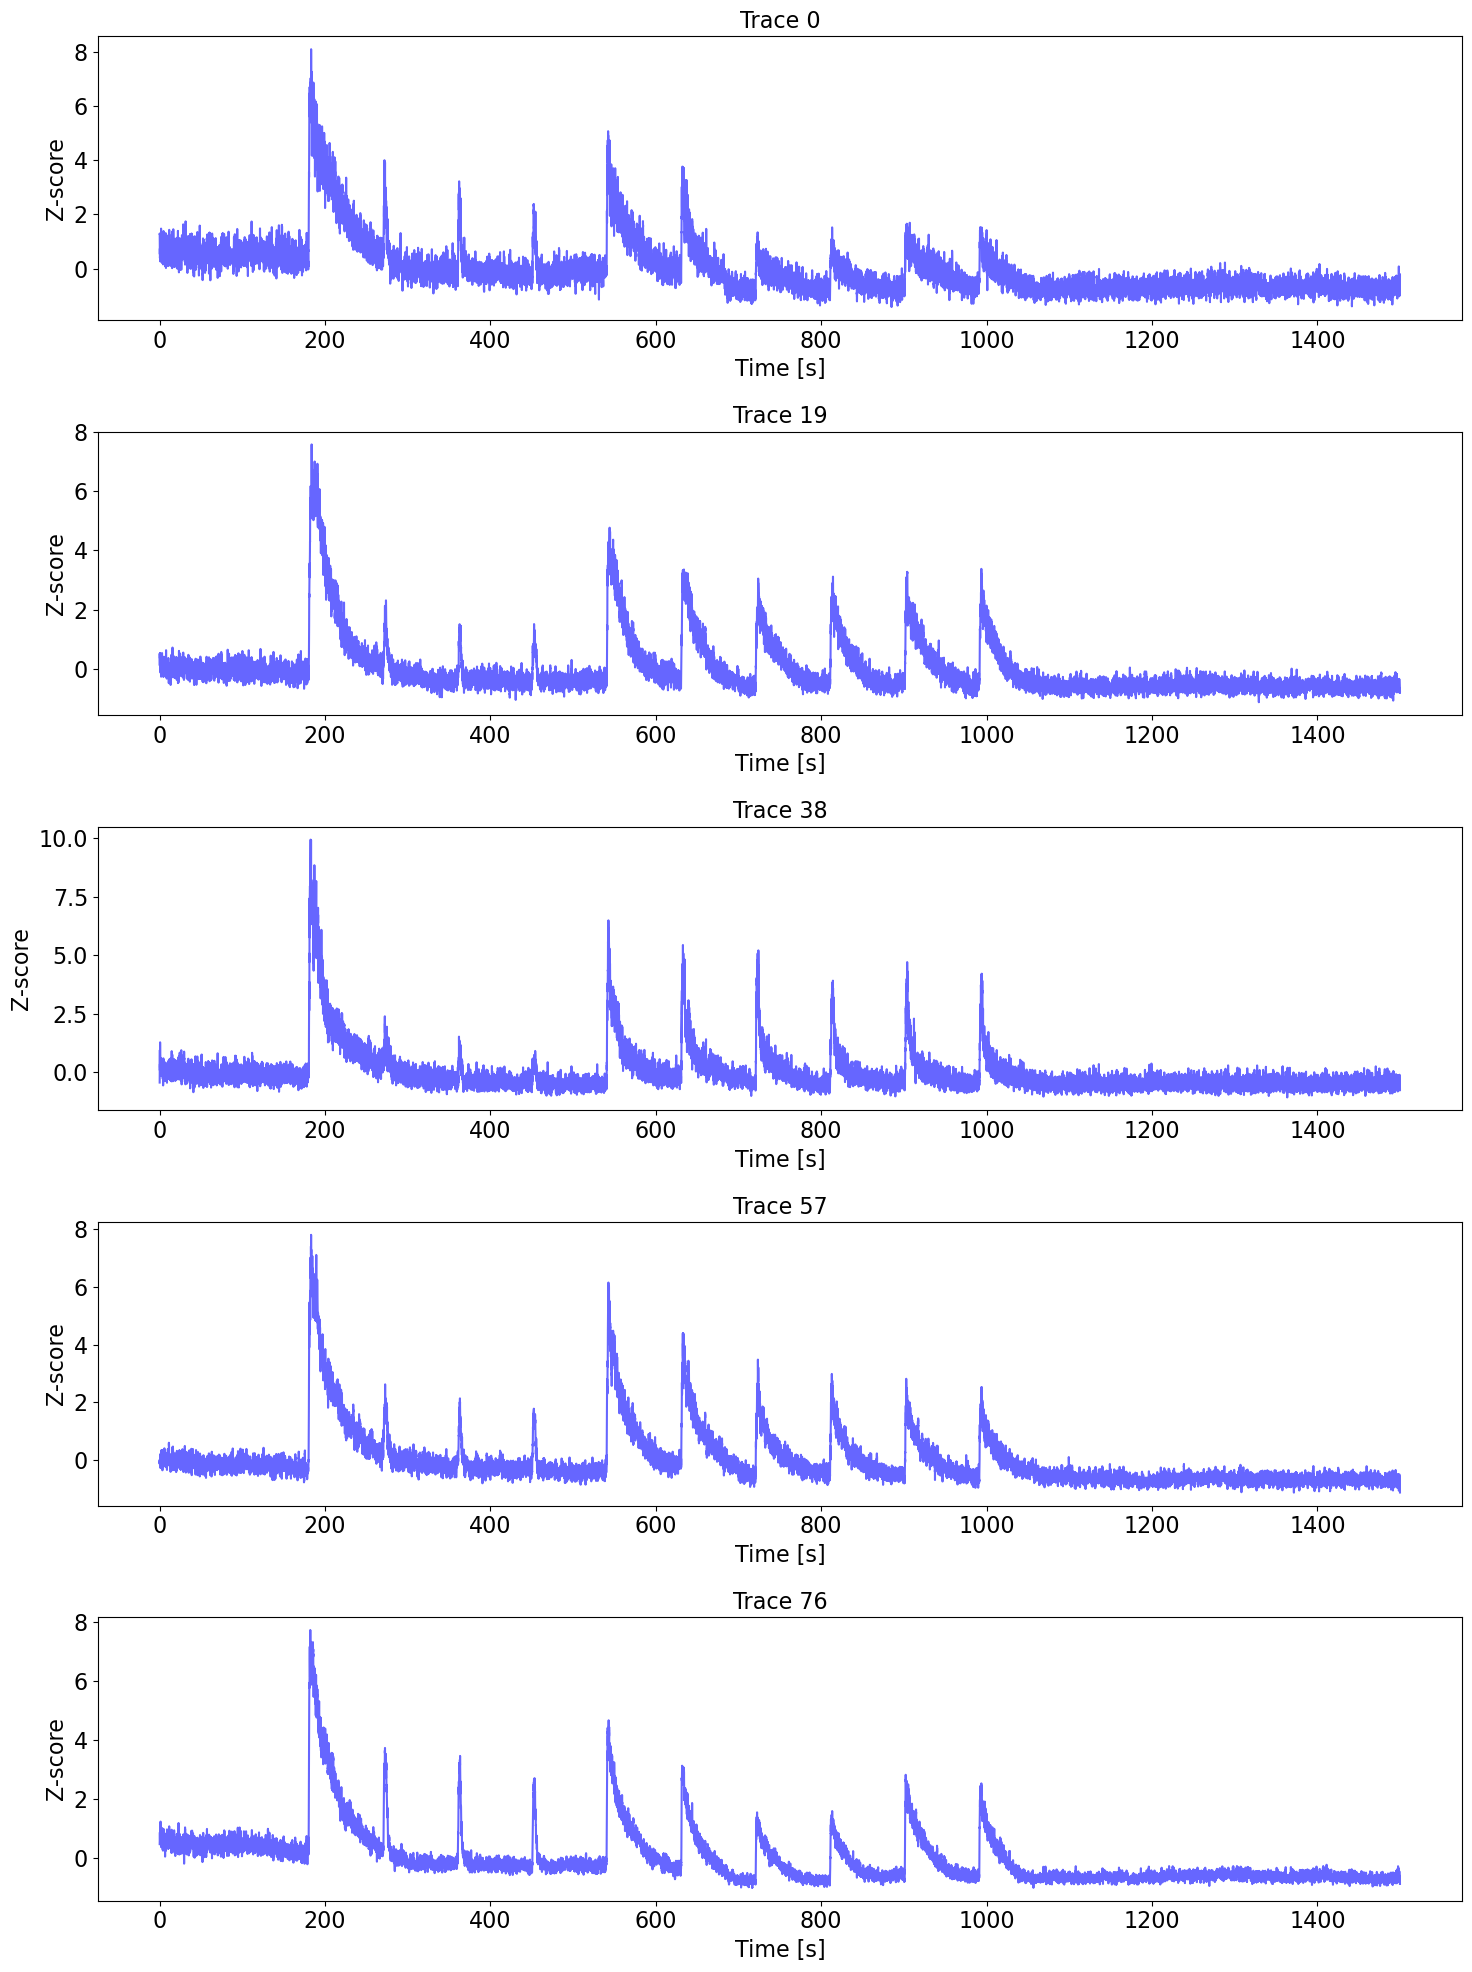

In [41]:
#sampling a random file
sample_file_idx = np.random.randint(0, len(sorted_files))

#plotting N_plots sorted traces with ascending SNR
N_plots = 5

#loading data
data = np.load(path_to_sorted+sorted_files[sample_file_idx])
traces = data['traces']

#selecting the traces to plot
n_traces = traces.shape[0]
interval = n_traces//N_plots
idx_plot = np.arange(0, n_traces, interval)

#plot in ascending order of SNR
fig, ax = plt.subplots(N_plots,1, figsize=(15,N_plots*4))
for i in range(N_plots):
    ax[i].plot(np.arange(len(traces[idx_plot[i], :]))/f_sam, traces[idx_plot[i], :], color = 'blue', alpha = 0.6)
    ax[i].set_title('Trace '+str(idx_plot[i]))
    ax[i].set_xlabel('Time [s]')
    ax[i].set_ylabel('Z-score')

#fig.suptitle('Sorted Traces for '+sorted_files[sample_file_idx].split('.npz')[0])
plt.tight_layout()
plt.savefig('results/main_results/sorted_traces_'+sorted_files[sample_file_idx].split('.npz')[0]+'.png')

## Filter traces by SNR

In [42]:
#selecting a top-percentange of traces to keep
top_percentage = 0.6

#creating a folder to store the data
if not os.path.exists('data/top{}_traces/'.format(top_percentage)):
    os.mkdir('data/top{}_traces/'.format(top_percentage))

In [28]:
counter_kept_traces = 0
counter_traces = 0

#loop over all the sorted files
for file in sorted_files:
    
        #loading data
        data = np.load(path_to_sorted+file)
        traces = data['traces']
        stimuli_idx = data['stimuli_idx']
    
        #selecting the top percentage of traces
        n_traces = traces.shape[0]
        n_top = round(n_traces*top_percentage)
        top_traces = traces[-n_top:, :]
        counter_kept_traces = counter_kept_traces + n_top
        counter_traces = counter_traces + n_traces
    
        #saving the top traces
        np.savez('data/top{}_traces/top{}_traces_'.format(top_percentage, top_percentage)+file.split('.npz')[0], traces = top_traces, stimuli_idx = stimuli_idx)

print('Number of traces kept:', counter_kept_traces, 'over', counter_traces)

Number of traces kept: 340 over 568


#### Selecting the top-percentange of traces used for the analysis

In [43]:
top_percentage = 0.6
path_to_traces = 'data/top{}_traces/'.format(top_percentage)
print(path_to_traces)

files = os.listdir(path_to_traces)
print('Number of files:', len(files))

data/top0.6_traces/
Number of files: 8


## De-noising of traces and saving pre-proccessed data

For the following analysis, I save a single npy file with filtered and cleaned traces and the array with the corresponding stimuli times.

### Gaussian filter

Apply gaussian filter for de-noising of high frequencies. Smoothing around 200 ms to match the trained model of CASCADE.

In [44]:
# Parameters for Gaussian smoothing
sigma = 6  # Standard deviation for Gaussian kernel corresponsing to a smoothing over ~200 ms (6*dt)

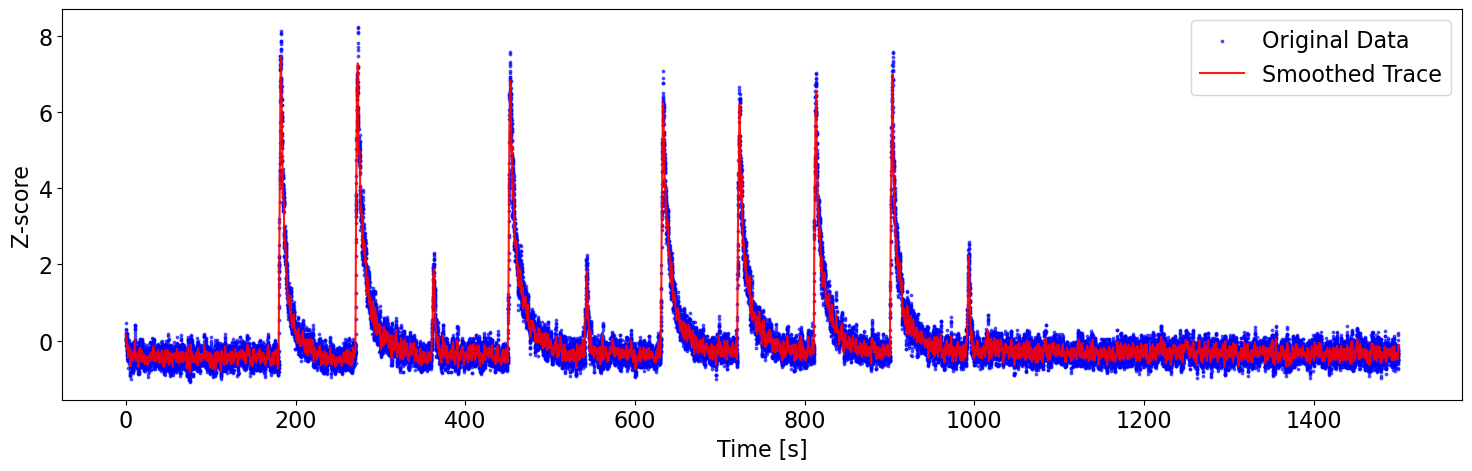

In [48]:
cleaned_traces = []
stimuli_idxs = []

#selecting random sample to plot
sample_file_idx = np.random.randint(0, len(files))
sample_trace = np.random.randint(0, 20)

for file in files:
    data = np.load(path_to_traces+file)

    traces = data['traces']
    n_traces = traces.shape[0]

    #saving the stimuli
    stimuli_idx = data['stimuli_idx']

    #smoothing the traces
    for i in range(n_traces):
        smooth_trace = gaussian_filter1d(traces[i, :], sigma)
        cleaned_traces.append(smooth_trace)

        #appending also the stimuli
        stimuli_idxs.append(stimuli_idx)

        if (i == sample_trace) and (file == files[sample_file_idx]):
            plt.figure(figsize=(15,5))
            #plt.title('Example of smoothed trace with Gaussian filter sigma = {}'.format(sigma))
            plt.scatter(np.arange(0, traces.shape[1])*dt*10**(-3), traces[i, :], label = 'Original Data',  s=3 , color = 'blue', alpha = 0.6)
            plt.plot(np.arange(0, traces.shape[1])*dt*10**(-3), smooth_trace, label = 'Smoothed Trace', color = 'red', alpha = 0.9)
            plt.legend()
            plt.xlabel('Time [s]')
            plt.ylabel('Z-score')
            plt.savefig('results/main_results/smoothed_trace_example_gaussian_filter_sigma{}.png'.format(sigma), pad_inches=0.1, bbox_inches='tight')

#Passing to store cleaned_traces as np.array
# Step 1: Determine the maximum length of the sublists
max_length = max(len(sublist) for sublist in cleaned_traces)

# Step 2: Pad each sublist to the maximum length
padded_arrays = [np.pad(arr, (0, max_length - len(arr)), mode='constant', constant_values=np.nan) for arr in cleaned_traces]

# Step 3: Convert to a numpy array
cleaned = np.array(padded_arrays)
stimuli = np.array(stimuli_idxs)

#saving the cleaned traces and the average stimuli index
np.save('data/cleaned_traces/cleaned_traces_top{}_gaussian_filter_sigma{}'.format(top_percentage, sigma), cleaned)
np.save('data/cleaned_traces/stimuli_idx_top{}_gaussian_filter_sigma{}'.format(top_percentage, sigma), stimuli)

## Loading pre-processed data and plot of example

In [49]:
#choosing the preprocessed data
top_percentage = 0.6
sigma = 6

In [50]:
# path to pre-process data
path_to_final_data = 'data/cleaned_traces/cleaned_traces_top{}_gaussian_filter_sigma{}.npy'.format(top_percentage, sigma)
path_to_stimuli = 'data/cleaned_traces/stimuli_idx_top{}_gaussian_filter_sigma{}.npy'.format(top_percentage, sigma)

#loading the cleaned traces
traces = np.load(path_to_final_data)

#loading the corresponding stimuli
stimuli_idx = np.load(path_to_stimuli).astype(int)

#useful for loops
n_traces = traces.shape[0]
N_stimuli = 10

#### Plot of examples of data

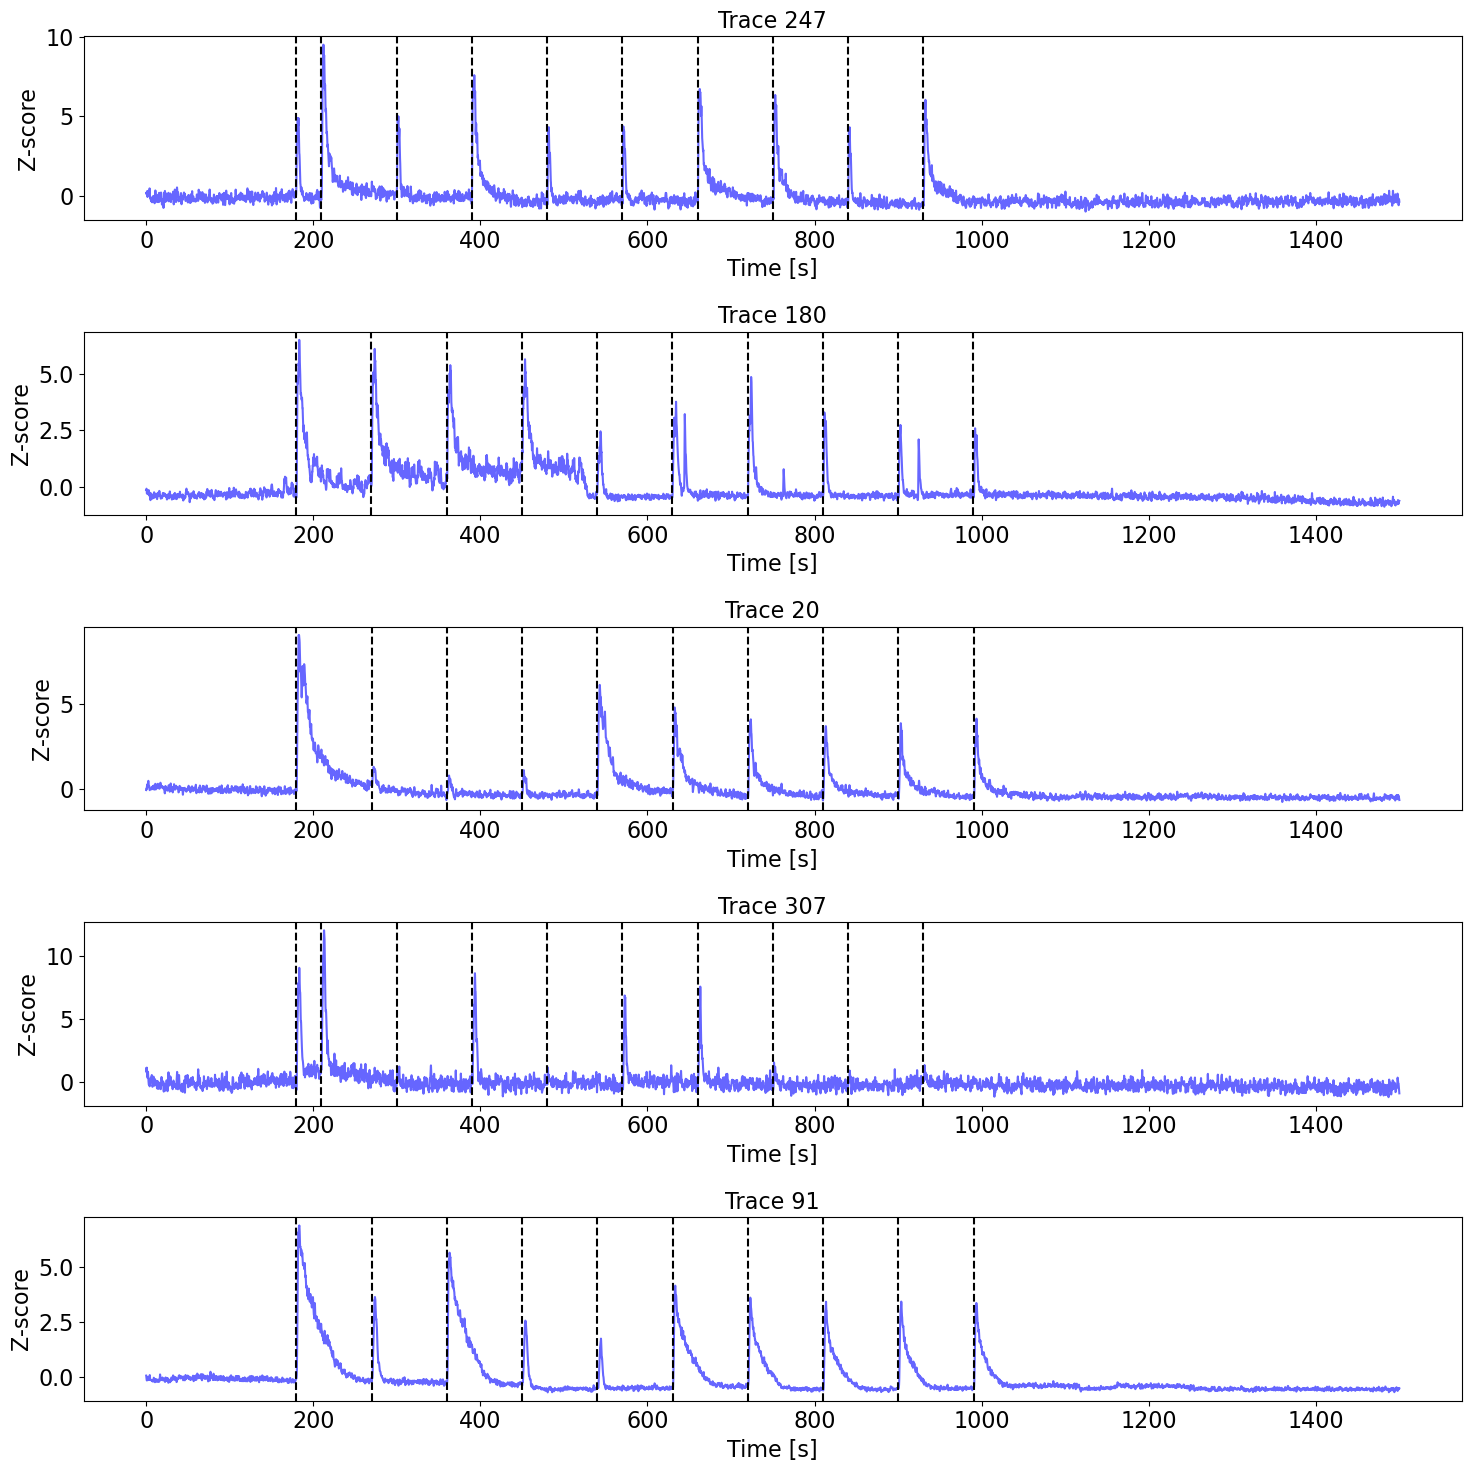

In [57]:
sample_traces = np.random.randint(0, traces.shape[0], 5)

#plotting the traces
fig, ax = plt.subplots(5,1, figsize=(15,15))
for i in range(5):
    ax[i].plot(np.arange(0, len(traces[sample_traces[i], :]))*dt*10**(-3), traces[sample_traces[i], :], color = 'blue', alpha = 0.6)
    ax[i].set_title('Trace '+str(sample_traces[i]))
    ax[i].set_xlabel('Time [s]')
    ax[i].set_ylabel('Z-score')
    for j in range(N_stimuli):
        ax[i].axvline(stimuli_idx[sample_traces[i], j]*dt*10**(-3), 0, 1, linestyle = '--', color = 'k', label='Stimuli')

#fig.suptitle('Example of final pre-processed traces')
plt.tight_layout()
plt.savefig('results/main_results/final_preprocessed_traces_example.png')

## Selecting intervalls of analysis

In [58]:
#hyperparameters
stimuli_window = 80*f_sam     #assuming that the duration of a perturbation due to a stimuli is 60 seconds

In [59]:
#define a function that given the indexes of stimulis, defines the periods of rest and stimuli
def periods_intervalls(stimuli, stimuli_window):

    initial_rest = np.arange(stimuli[0])
    final_rest = np.arange(stimuli[-1]+stimuli_window, 40_000)
    stimuli_periods = [np.arange(st,min(st+stimuli_window, st+stimuli[i+1])) for i, st in enumerate(stimuli[:-1])]
    stimuli_periods.append(np.arange(stimuli[-1], stimuli[-1]+stimuli_window))
    complete_stimuli_interval = np.arange(stimuli[0]-stimuli_window, stimuli[-1]+stimuli_window)
    complete_interval = np.arange(0, 40_000)

    return initial_rest, final_rest, stimuli_periods, complete_stimuli_interval, complete_interval

#### Plot example of different considered periods

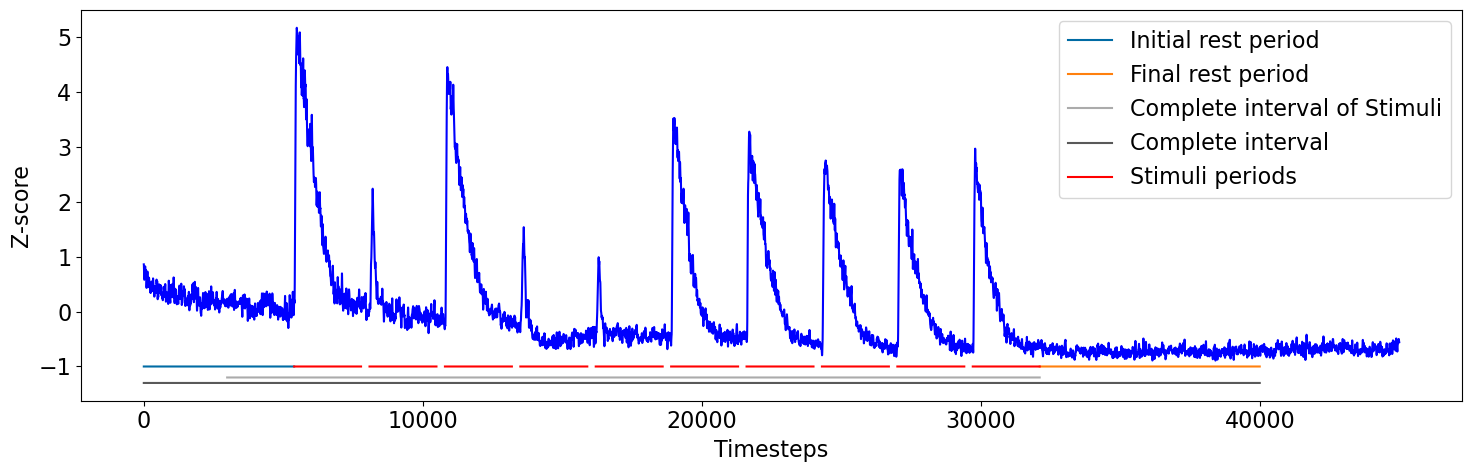

In [62]:
#selecting a random trace
n = np.random.randint(0, traces.shape[0])
trace = traces[n, :]
stimuli = stimuli_idx[n, :]

#computing the intevalls
initial_rest, final_rest, stimuli_periods, complete_stimuli_interval, complete_interval = periods_intervalls(stimuli, stimuli_window)

plt.figure(figsize=(15,5))
plt.plot(traces[n, :], color = 'blue')
plt.plot(initial_rest, np.ones(len(initial_rest))*(-1), label = 'Initial rest period')
plt.plot(final_rest, np.ones(len(final_rest))*(-1), label = 'Final rest period')
plt.plot(complete_stimuli_interval, np.ones(len(complete_stimuli_interval))*(-1.2), label = 'Complete interval of Stimuli')
plt.plot(complete_interval, np.ones(len(complete_interval))*(-1.3), label = 'Complete interval')

plt.plot(stimuli_periods[0], np.ones(len(stimuli_periods[0]))*(-1), color = 'red', label = 'Stimuli periods')


for st in stimuli_periods[1:]:
    plt.plot(st, np.ones(len(st))*(-1), color = 'red')
plt.legend()

#plt.title('Example of intervals of rest and stimuli periods')
plt.xlabel('Timesteps')
plt.ylabel('Z-score')

plt.savefig('results/main_results/intervals_example.png')

## Exponential fitting of Calcium traces

In [63]:
#estimating the charecteristic times from exponential fitting

# Double exponential decay function
def exponential_decay(x, a1, b1, a2, b2, lag, c):
    return np.abs(a1) * np.exp(-b1 * x) + c + np.abs(a2)*np.exp(-b2*np.abs((x-lag)))

#fit procedure
def exponential_decay_fit(trace):
    y = trace
    t_asc = np.argmax(y)
    y_exp = y[t_asc:]
    x = np.arange(len(y_exp))

    try:
        [a1, b1, a2, b2, lag, c], cov = curve_fit(exponential_decay, x, y_exp, p0=(2, 5e-3, 1, 5e-3, 1000, 0), maxfev=10000)
        t_half1 = np.log(2)/b1
        t_half2 = np.log(2)/b2
    
    except:
        [a1, b1, a2, b2, lag, c] = [0, 0, 0, 0, 0, 0]
        t_half1 = None
        t_half2 = None

    return [t_asc, t_half1, t_half2, a1, b1, a2, b2, lag, c] 

In [64]:
#hyperparameters
p = 0.02 #probability of saving the plot

In [65]:
#to store the timescale
t_asc_list = []
t_half1_list = []
t_half2_list = []
lag_list = []

for n in range(n_traces):  #loop on traces

    trace_complete = traces[n, :]  #selecting the trace
    stimuli = stimuli_idx[n, :]  #selecting the stimuli

    #computing the intervals
    initial_rest, final_rest, stimuli_periods, complete_stimuli_interval, complete_interval = periods_intervalls(stimuli, stimuli_window)
    

    for i in range(N_stimuli):  #loop on stimuli

        trace = trace_complete[stimuli_periods[i]]
        #selecting the trace in the interval of the stimuli
        [t_asc, t_half1, t_half2, a1, b1, a2, b2, lag, c] = exponential_decay_fit(trace)  #fitting a double exponential

        #saving the files
        t_asc_list.append(t_asc)
        t_half1_list.append(t_half1)
        t_half2_list.append(t_half2)
        lag_list.append(lag)

        if np.random.random()<p:
            #print([t_asc, t_half1, t_half2, a1, b1, a2, b2, lag, c])
            plt.figure(figsize=(12,6))
            plt.scatter(np.arange(0, stimuli_window)*dt*10**(-3), trace, color = 'blue', s  = 4, alpha = 0.8, label = 'Smoothed Trace')
            plt.plot(np.arange(t_asc, stimuli_window)*dt*10**(-3), exponential_decay(np.arange(stimuli_window-t_asc), a1, b1, a2, b2, lag, c), color = 'red', label = 'Fit')
            plt.xlabel('Time [s]')
            plt.ylabel('Z-score')
            plt.legend()
            plt.savefig('results/exponential_fitting/fitting_examples/fitting_example_trace{}_stimuli{}.png'.format(n, i))
            plt.close()

#saving the timescales
t_asc = np.array(t_asc_list)
t_half1 = np.array(t_half1_list)
t_half2 = np.array(t_half2_list)
lag = np.array(lag_list)

t_half1 = t_half1[t_half1 != None].astype(float)
t_half2 = t_half2[t_half2 != None].astype(float)
lag = lag[lag != None].astype(float)

np.savez('results/exponential_fitting/exp_fit_times', t_asc = t_asc, t_half1 = t_half1, t_half2 = t_half2, lag = lag)


/home/zenn/anaconda3/envs/VCS/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/tmp/ipykernel_14056/1333809963.py:5: RuntimeWarning: overflow encountered in exp
  return np.abs(a1) * np.exp(-b1 * x) + c + np.abs(a2)*np.exp(-b2*np.abs((x-lag)))


### Histogramming the fitting times

In [90]:
#loading the data
data = np.load('results/exponential_fitting/exp_fit_times.npz')
t_asc = data['t_asc']*dt
t_half1 = data['t_half1']*dt
t_half2 = data['t_half2']*dt
lag = data['lag']*dt

In [91]:
#cleaning the data
Min = 0
Max = 20*10**3
Max2 = 60*10**3

t_half1 = t_half1[t_half1>Min]
t_half1 = t_half1[t_half1<Max]

t_half2 = t_half2[t_half2>Min]
t_half2 = t_half2[t_half2<Max]

lag = lag[lag>Min]
lag = lag[lag<Max2]

t_asc = t_asc[t_asc>Min]
t_asc = t_asc[t_asc<Max]

#converting in seconds
t_half1 = t_half1/1000
t_half2 = t_half2/1000
lag = lag/1000
t_asc = t_asc/1000

In [92]:
#function to compute the mode of an array
def mode_calculator(array):
    counts, bin_edges = np.histogram(array, bins = int(np.sqrt(len(array))))
    max_idx = np.argmax(counts)
    mode = (bin_edges[max_idx]+bin_edges[max_idx+1])/2
    return mode

In [93]:
#statistics
t_half1_mean = np.mean(t_half1)
t_half1_std = np.std(t_half1)
t_half1_mode = mode_calculator(t_half1)
t_half1_median = np.median(t_half1)

t_asc_mean = np.mean(t_asc)
t_asc_std = np.std(t_asc)
t_asc_mode = mode_calculator(t_asc)
t_asc_median = np.median(t_asc)

t_half2_mean = np.mean(t_half2)
t_half2_std = np.std(t_half2)
t_half2_mode = mode_calculator(t_half2)
t_half2_median = np.median(t_half2)

lag_mean = np.mean(lag)
lag_std = np.std(lag)
lag_mode = mode_calculator(lag)
lag_median = np.median(lag)

print('--------- Statistics on timescales: --------------')
print('t_half1_mean [s]:', t_half1_mean)
print('t_half1_std [s]:', t_half1_std)
print('t_half1_mode [s]:', t_half1_mode)
print('t_half1_median [s]:', t_half1_median)
print('--------------------------------------')
print('t_asc_mean [s]:', t_asc_mean)
print('t_asc_std [s]:', t_asc_std)
print('t_asc_mode [s]:', t_asc_mode)
print('t_asc_median [s]:', t_asc_median)
print('--------------------------------------')
print('t_half2_mean [s]:', t_half2_mean)
print('t_half2_std [s]:', t_half2_std)
print('t_half2_mode [s]:', t_half2_mode)
print('t_half2_median[s]:', t_half2_median)
print('--------------------------------------')
print('lag_mean [s]:', lag_mean)
print('lag_std [s]:', lag_std)
print('lag_mode [s]:', lag_mode)
print('lag_median [s]:', lag_median)


--------- Statistics on timescales: --------------
t_half1_mean [s]: 3.829502241370181
t_half1_std [s]: 3.8878049125217222
t_half1_mode [s]: 1.3197634013765691
t_half1_median [s]: 2.0344734661501818
--------------------------------------
t_asc_mean [s]: 3.1588535164377864
t_asc_std [s]: 1.6279709942428038
t_asc_mode [s]: 3.0619047619047626
t_asc_median [s]: 3.1
--------------------------------------
t_half2_mean [s]: 5.740742018793653
t_half2_std [s]: 5.326840528498123
t_half2_mode [s]: 0.22002357816166374
t_half2_median[s]: 4.474270943399835
--------------------------------------
lag_mean [s]: 24.65055631071115
lag_std [s]: 12.919505078677862
lag_mode [s]: 32.667425591796416
lag_median [s]: 25.543785033739685


In [83]:
fig,ax = plt.subplots(2,2, figsize=(12,10))

ax[0, 0].hist(t_half1, density = True, bins = 50, color = 'r', alpha = 0.7, label = r'$\tau_1$')
ax[0, 0].set_xlabel(r'$\tau_1$ [s]')
ax[0, 0].legend()
ax[0, 0].set_ylabel('Density')
ax[0, 0].text(0.56, 0.6, 'Mean = {:.2f} [s]\nMode = {:.2f} [s]\nMedian = {:.2f} [s]\nStd = {:.2f} [s]'.format(t_half1_mean, t_half1_mode, t_half1_median, t_half1_std), transform=ax[0, 0].transAxes)

ax[0, 1].hist(t_half2, density = True, bins = 50, color = 'g', alpha = 0.7, label = r'$\tau_2$')
ax[0, 1].set_xlabel(r'$\tau_2$ [s]')
ax[0, 1].legend()
ax[0, 1].set_ylabel('Density')
ax[0, 1].text(0.56, 0.6, 'Mean = {:.2f} [s]\nMode = {:.2f} [s]\nMedian = {:.2f} [s]\nStd = {:.2f} [s]'.format(t_half2_mean, t_half2_mode, t_half2_median, t_half2_std), transform=ax[0, 1].transAxes)

ax[1, 0].hist(t_asc, density = True, bins = 50, color = 'y', alpha = 0.7, label = r'$t_{asc}$')
ax[1, 0].set_xlabel(r'$t_{asc}$ [s]')
ax[1, 0].legend()
ax[1, 0].set_ylabel('Density')
ax[1, 0].text(0.56, 0.6, 'Mean = {:.2f} [s]\nMode = {:.2f} [s]\nMedian = {:.2f} [s]\nStd = {:.2f} [s]'.format(t_asc_mean, t_asc_mode, t_asc_median, t_asc_std), transform=ax[1, 0].transAxes)

ax[1, 1].hist(lag, density = True, bins = 50, color = 'b', alpha = 0.7, label = r'$t_{lag}$')
ax[1, 1].set_xlabel(r'$t_{lag}$ [s]')
ax[1, 1].legend()
ax[1, 1].set_ylabel('Density')
ax[1, 1].text(0.02, 0.73, 'Mean = {:.2f} [s]\nMode = {:.2f} [s]\nMedian = {:.2f} [s]\nStd = {:.2f} [s]'.format(lag_mean, lag_mode, lag_median, lag_std), transform=ax[1, 1].transAxes)


plt.savefig('results/exponential_fitting/histograms_exponential_fitting_times.png', pad_inches = 0.1, bbox_inches = 'tight')


#### Estimating the expected lag between the exponentials in the double exponential decay in timesteps

In [94]:
lag_timestep = int(lag_mode*f_sam)
print('Lag in timesteps:', lag_timestep)

t_half1_timestep = int(t_half1_median*f_sam)
print('t_half1 in timesteps:', t_half1_timestep)

t_half2_timestep = int(t_half2_median*f_sam)
print('t_half2 in timesteps:', t_half2_timestep)

t_asc_timestep = int(t_asc_mode*f_sam)
print('t_asc in timesteps:', t_asc_timestep)

Lag in timesteps: 980
t_half1 in timesteps: 61
t_half2 in timesteps: 134
t_asc in timesteps: 91


## Autocorrelation function

In [138]:
n_traces = traces.shape[0]
print('Total number of traces:', n_traces)

Total number of traces: 340


In [139]:
#hyperparameters
p = 0.005 #prob of saving a plot

#Half-Width at Half-Maximum Estimator
def HWHM(C):
    half = 0.5
    idx = np.argmin(np.abs(C - half))

    return idx

#### Autocorrelation Function on the entire trace

In [140]:
average_C = np.zeros(27_000)
average_C_total = np.zeros(40_000)

count = 0

for n in range(n_traces):

    #selecting the trace
    trace = traces[n, :]
    #selecting the stimuli
    stimuli = stimuli_idx[n, :]

    #computing the intervals
    initial_rest, final_rest, stimuli_periods, complete_stimuli_interval, complete_interval = periods_intervalls(stimuli, stimuli_window)

    # Compute the autocorrelation function for a range of lags
    C = sm.tsa.acf(trace[complete_stimuli_interval], nlags= len(average_C)-1)
    C_total = sm.tsa.acf(trace[complete_interval], nlags= len(average_C_total)-1)

    average_C = average_C + C

    if(not np.isnan(C_total).any()):
        count = count + 1    
        average_C_total = average_C_total + C_total

average_C = average_C/n_traces
average_C_total = average_C_total/count

In [141]:
#plotting the acf in the stimuli period
plt.figure(figsize=(15,5))
plt.plot(np.arange(0, 27_000)*dt*10**(-3), average_C, color = 'blue')
plt.xlabel(r'$\Delta t$ [s]')
plt.ylabel(r'C($\Delta t$)')

#plotting the distance between stimuli
plt.axvline(0, color = 'black', linestyle = '--', label = 'Stimuli Period', alpha = 0.4)
plt.axvline(lag_mode, color = 'black', linestyle = '-.', label = r'Mode of second exponential lag $t_{lag}$', alpha = 0.4)

for i in range(1, 10):
    plt.axvline(i*90, color = 'black', linestyle = '--', alpha = 0.4)
    plt.axvline(i*90+lag_mode, color= 'black', linestyle = '-.', alpha = 0.4)

plt.legend()
plt.savefig('results/autocorrelation_functions/acf_stimuli_period.png', pad_inches = 0.1, bbox_inches = 'tight')

In [142]:
#plotting the acf in the stimuli period
plt.figure(figsize=(15,5))
plt.plot(np.arange(0, 27_000)*dt*10**(-3), average_C, color = 'blue')
plt.xlabel(r'$\Delta t$ [s]')
plt.ylabel(r'C($\Delta t$)')
#plt.title('Average Autocorrelation Function along the stimuli period')

#plotting the distance between stimuli
plt.axvline(0, color = 'black', linestyle = '--', label = 'Stimuli lag', alpha = 0.4)
plt.axvline(30, color = 'black', linestyle = '-.', label = 'Second exponential lag', alpha = 0.4)

for i in range(1, 10):
    plt.axvline(i*90, color = 'black', linestyle = '--', alpha = 0.4)
    plt.axvline(i*90+30, color= 'black', linestyle = '-.', alpha = 0.4)
    #plt.axvline(i*90+t_half1_mode, color= 'green', linestyle = '-.', alpha = 0.4)
    #plt.axvline(i*90+t_asc_mode, color= 'red', linestyle = '-.', alpha = 0.4)
plt.xlim(100, 300)

plt.legend()
plt.savefig('results/autocorrelation_functions/acf_stimuli_period_zoom.png')

### Autocorrelation function of the initial rest period

In [143]:
p = 0.1

In [144]:
average_C = np.zeros(5200)

for n in range(n_traces):

    #selecting the trace
    trace = traces[n, :]
    #selecting the stimuli
    stimuli = stimuli_idx[n, :]
    #computing the intervals
    initial_rest, final_rest, stimuli_periods, complete_stimuli_interval, complete_interval = periods_intervalls(stimuli, stimuli_window)

    # Compute the autocorrelation function for a range of lags
    C = sm.tsa.acf(trace[initial_rest], nlags= len(average_C)-1)

    if np.random.random()<p:
        plt.figure(figsize=(8,5))
        plt.plot(np.arange(0, 200)*dt*10**(-3), C[:200], color = 'blue', alpha = 0.8)
        plt.axvline(HWHM(C)*dt*10**(-3), 0, 1, color = 'black', linestyle =  '--', label = 'HWHM')
        plt.legend()
        plt.xlabel(r'$\Delta t$ [s]')
        plt.ylabel(r'C($\Delta t$)')
        plt.savefig('results/autocorrelation_functions/examples_of_acf/acf_trace{}_stimulus{}'.format(n, i), pad_inches = 0.1, bbox_inches = 'tight')
        plt.close()

    average_C = average_C + C

average_C = average_C/n_traces
plt.figure(figsize=(15,5))
plt.plot(average_C, color = 'blue')
plt.xlabel('Lag steps')
plt.ylabel('Autocorrelation')
plt.title('Average Autocorrelation Function at initial rest period')

plt.savefig('results/autocorrelation_functions/atf_initial_rest_complete', pad_inches = 0.1, bbox_inches = 'tight')

In [145]:
rest_average_C = average_C[:201]

#### Zoom of the autocorrelation time at rest

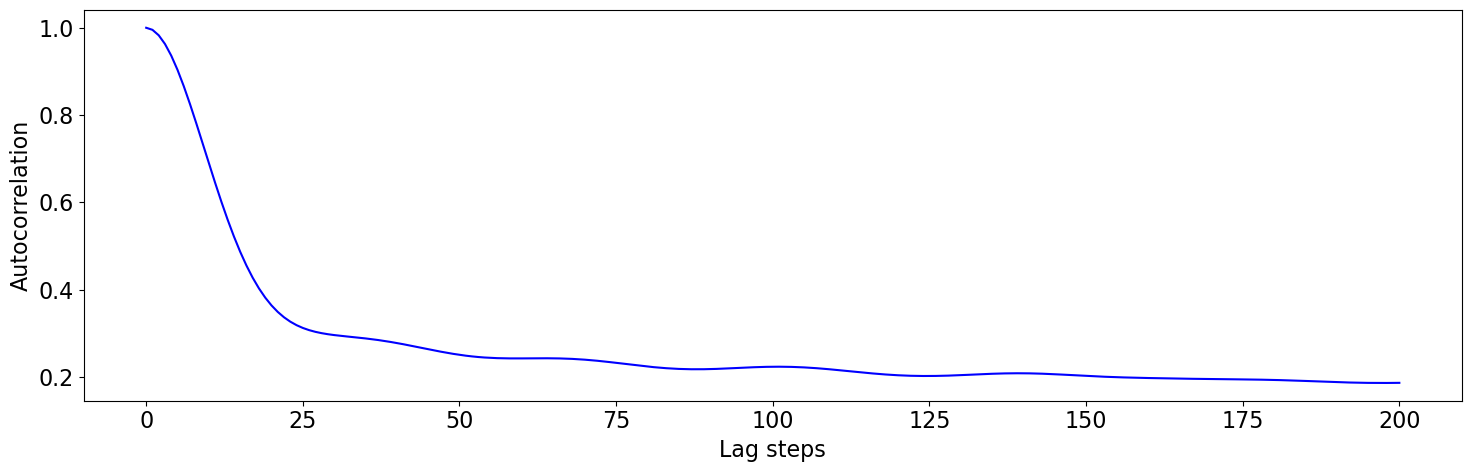

In [146]:
nlags = 201
average_C = np.zeros(nlags)

for n in range(n_traces):

    #selecting the trace
    trace = traces[n, :]
    #selecting the stimuli
    stimuli = stimuli_idx[n, :]
    #computing the intervals
    initial_rest, final_rest, stimuli_periods, complete_stimuli_interval, complete_interval = periods_intervalls(stimuli, stimuli_window)

    # Compute the autocorrelation function for a range of lags
    C = sm.tsa.acf(trace[initial_rest], nlags= nlags-1)

    average_C = average_C + C

average_C = average_C/n_traces
plt.figure(figsize=(15,5))
plt.plot(average_C, color = 'blue')
plt.xlabel('Lag steps')
plt.ylabel('Autocorrelation')
#plt.title('Average Autocorrelation Function at initial rest period')

plt.savefig('results/autocorrelation_functions/atf_initial_rest_nlags{}'.format(nlags), pad_inches = 0.1, bbox_inches = 'tight')

### Autocorrelation function for the final rest period

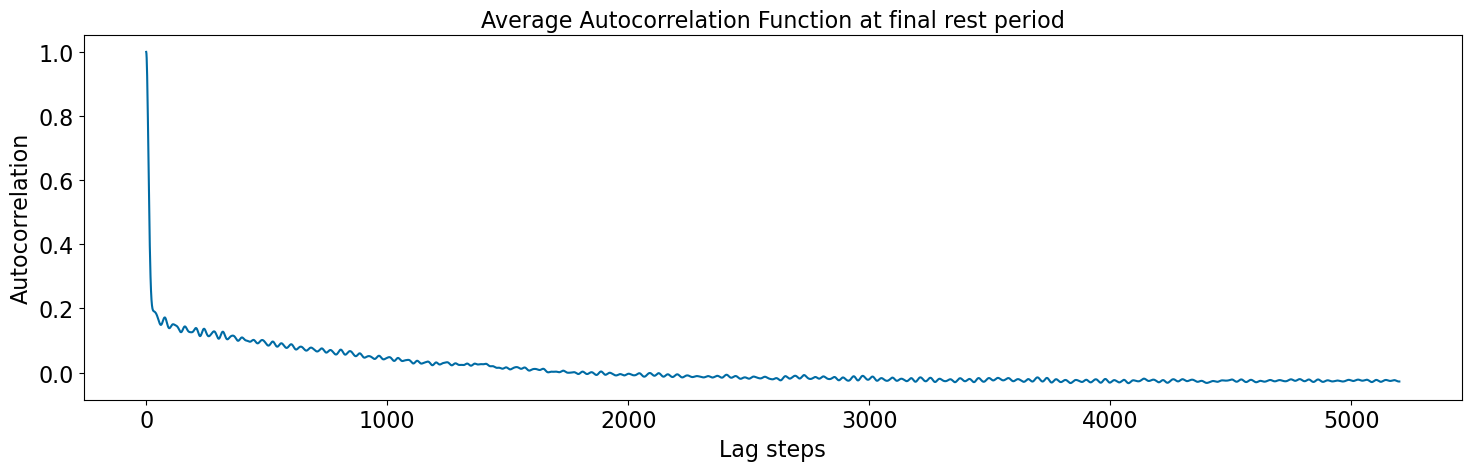

In [147]:
average_C = np.zeros(5_200)

for n in range(n_traces):

    #selecting the trace
    trace = np.nan_to_num(traces[n, :], 0)
    #selecting the stimuli
    stimuli = stimuli_idx[n, :]
    #computing the intervals
    initial_rest, final_rest, stimuli_periods, complete_stimuli_interval, complete_interval = periods_intervalls(stimuli, stimuli_window)

    # Compute the autocorrelation function for a range of lags
    C = sm.tsa.acf(trace[final_rest], nlags= len(average_C)-1)

    if np.random.random()<p:
        plt.figure(figsize=(15,5))
        plt.plot(C)
        plt.axvline(HWHM(C), 0, 1, color = 'black', linestyle =  '--', label = 'HWHM')
        plt.legend()
        plt.xlabel('Lag steps')
        plt.ylabel('Autocorrelation')
        plt.title('Autocorrelation Function for trace {} and stimulus {}'.format(n, i))
        plt.savefig('results/autocorrelation_functions/examples_of_acf/acf_trace{}_final_rest'.format(n))
        plt.close()

    average_C = average_C + C

average_C = average_C/n_traces

plt.figure(figsize=(15,5))
plt.plot(average_C)
plt.xlabel('Lag steps')
plt.ylabel('Autocorrelation')
plt.title('Average Autocorrelation Function at final rest period')

plt.savefig('results/autocorrelation_functions/atf_final_rest_complete')

#### Zoom over the first 100 lag steps

In [148]:
nlags = 201
average_C = np.zeros(nlags)

for n in range(n_traces):
            
        #selecting the trace
        trace = np.nan_to_num(traces[n, :], 0)
        #selecting the stimuli
        stimuli = stimuli_idx[n, :]
        #computing the intervals
        initial_rest, final_rest, stimuli_periods, complete_stimuli_interval, complete_interval = periods_intervalls(stimuli, stimuli_window)
    
        # Compute the autocorrelation function for a range of lags
        C = sm.tsa.acf(trace[final_rest], nlags= nlags-1)

        average_C = average_C + C

average_C = average_C/n_traces

plt.figure(figsize=(15,5))
plt.plot(average_C)
plt.xlabel('Lag steps')
plt.ylabel('Autocorrelation')
plt.title('Average Autocorrelation Function at final rest period')

plt.savefig('results/autocorrelation_functions/atf_final_rest_nlags{}'.format(nlags))

### Autocorrelation of periods of stimuli

In [149]:
#hyper parameter
p = 0.02 #probability of saving an example of acf

In [150]:
average_C = np.zeros(stimuli_window)

for n in range(n_traces):  #loop on traces
    trace = traces[n, :]
    #selecting the stimuli
    stimuli = stimuli_idx[n, :]
    #computing the intervals
    initial_rest, final_rest, stimuli_periods, complete_stimuli_interval, complete_interval = periods_intervalls(stimuli, stimuli_window)

    for i in range(N_stimuli):   #loop on stimolus

        trace_interval = trace[stimuli_periods[i]]

        C = sm.tsa.acf(trace_interval, nlags = stimuli_window)

        if np.random.random()<p:
            plt.figure(figsize=(8,5))
            plt.plot(np.arange(0, 200)*dt*10**(-3), C[:200], color = 'blue', alpha = 0.8)
            plt.axvline(HWHM(C)*dt*10**(-3), 0, 1, color = 'black', linestyle =  '--', label = 'HWHM')
            plt.legend()
            plt.xlabel(r'$\Delta t$ [s]')
            plt.ylabel(r'C($\Delta t$)')
            plt.savefig('results/autocorrelation_functions/examples_of_acf/acf_trace{}_stimulus{}'.format(n, i), pad_inches = 0.1, bbox_inches = 'tight')
            plt.close()

        average_C = average_C + C   #averaging the autocorrelation functions

average_C = average_C/(n_traces*N_stimuli)

In [151]:
stimuli_average_C = average_C[:201]

In [152]:
#plot

plt.figure(figsize=(15,5))
plt.plot(average_C)
plt.xlabel('Lag steps')
plt.ylabel('Autocorrelation')
plt.title('Average Autocorrelation Function during Stimulus')

plt.savefig('results/autocorrelation_functions/acf_at_stimulus')


#### Autocorrelation function at the beginning of the stimulus

In [153]:
#plot

plt.figure(figsize=(15,5))
plt.plot(average_C)
plt.xlabel('Lag steps')
plt.xlim(xmin = 0, xmax = 201)
plt.ylim(ymin = average_C[200]-0.1, ymax = 1+0.1)
plt.ylabel('Autocorrelation')
plt.title('Average Autocorrelation Function during Stimulus')

plt.savefig('results/autocorrelation_functions/acf_at_stimulus_zoom')

#### Comparison stimuli and rest period

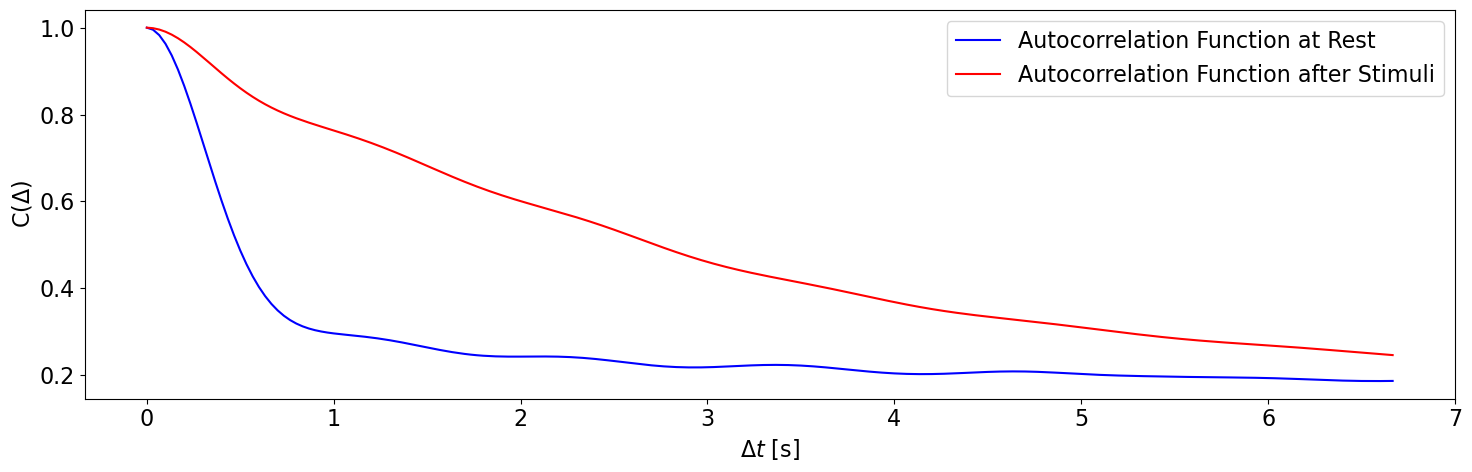

In [154]:
plt.figure(figsize=(15,5))
plt.plot(np.arange(len(rest_average_C))*dt*10**(-3), rest_average_C, color = 'blue', label = 'Autocorrelation Function at Rest')
plt.plot(np.arange(len(stimuli_average_C))*dt*10**(-3), stimuli_average_C, color = 'red', label = 'Autocorrelation Function after Stimuli')
plt.xlabel(r'$\Delta t$ [s]')
plt.ylabel(r'C($\Delta$)')
plt.legend()

plt.savefig('results/autocorrelation_functions/acf_rest_vs_stimuli', pad_inches = 0.1, bbox_inches = 'tight')

## Autocorrelation times distribution

Here we compute the autocorrelatio times as Half-Width at Half-Maximum of the autocorrelation functions for the resti periods and the stimuli.

In [155]:
#Half-Width at Half-Maximum Estimator
def HWHM(C):
    half = 0.5
    idx = np.argmin(np.abs(C - half))

    return idx

#### Autocorrelation times at rest

In [156]:
#hyperparameter
n_lag = 1000

#from autocorrelation functions we see HWHM(C)<<1000

In [157]:
tau_in = []
tau_end = []

for n in range(n_traces):

    #selecting the trace
    trace = traces[n, :]
    #selecting the stimuli
    stimuli = stimuli_idx[n, :]
    #computing the intervals
    initial_rest, final_rest, stimuli_periods, complete_stimuli_interval, complete_interval = periods_intervalls(stimuli, stimuli_window)

    # Initial rest
    C_in = sm.tsa.acf(trace[initial_rest], nlags= n_lag)
    tau_in.append(HWHM(C_in)*dt)

    #Final rest
    C_end = sm.tsa.acf(trace[final_rest], nlags = n_lag)
    tau_end.append(HWHM(C_end)*dt)    

In [159]:
#saving the data
tau_in = np.array(tau_in)
tau_end = np.array(tau_end)
tau_rest = np.concatenate([tau_in, tau_end])

np.savez('results/autocorrelation_times/act_rest', tau_in = tau_in, tau_end = tau_end, tau_rest = tau_rest)

#### Hitogramming the autocorrelation times at rest

In [160]:
#bin edges for histogramm
Min = 6*dt
Max = 40*dt

bin_edges = np.arange(6, 40)*dt

print('Min:', Min, '[ms]\t', 'Max:', Max, '[ms]')  

Min: 200.0 [ms]	 Max: 1333.3333333333335 [ms]


In [161]:
#loading the data
data = np.load('results/autocorrelation_times/act_rest.npz')
tau_in = data['tau_in']
tau_end = data['tau_end']

In [162]:
#cleaning of the data
tau_in = tau_in[tau_in>Min]
tau_in = tau_in[tau_in<Max]

tau_end = tau_end[tau_end>Min]
tau_end = tau_end[tau_end<Max]

tau_rest = np.concatenate([tau_in, tau_end])

In [163]:
#statistics of taus
mean_in = np.mean(tau_in)
mean_end = np.mean(tau_end)
mean_rest = np.mean(tau_rest)

mode_in = stats.mode(tau_in)[0]
mode_end = stats.mode(tau_end)[0]
mode_rest = stats.mode(tau_rest)[0]

median_in = np.median(tau_in)
median_end = np.median(tau_end)
median_rest = np.median(tau_rest)

std_in = np.std(tau_in)
std_end = np.std(tau_end)
std_rest = np.std(tau_rest)

print('Mean tau in:', mean_in, '[ms]\t', 'Mean tau end:', mean_end, '[ms]\t', 'Mean tau rest:', mean_rest, '[ms]')
print('Mode tau in:', mode_in, '[ms]\t', 'Mode tau end:', mode_end, '[ms]\t', 'Mode tau rest:', mode_rest, '[ms]')
print('Median tau in:', median_in, '[ms]\t', 'Median tau end:', median_end, '[ms]\t', 'Median tau rest:', median_rest, '[ms]')
print('Standard deviation tau in:', std_in, '[ms]\t', 'Standard deviation tau end:', std_end, '[ms]\t', 'Standard deviation tau rest:', std_rest, '[ms]')

Mean tau in: 490.0462962962963 [ms]	 Mean tau end: 434.91062039957944 [ms]	 Mean tau rest: 461.1570247933884 [ms]
Mode tau in: 400.0 [ms]	 Mode tau end: 400.0 [ms]	 Mode tau rest: 400.0 [ms]
Median tau in: 433.33333333333337 [ms]	 Median tau end: 400.0 [ms]	 Median tau rest: 433.33333333333337 [ms]
Standard deviation tau in: 149.20467450348193 [ms]	 Standard deviation tau end: 110.129933470095 [ms]	 Standard deviation tau rest: 133.0815189212392 [ms]


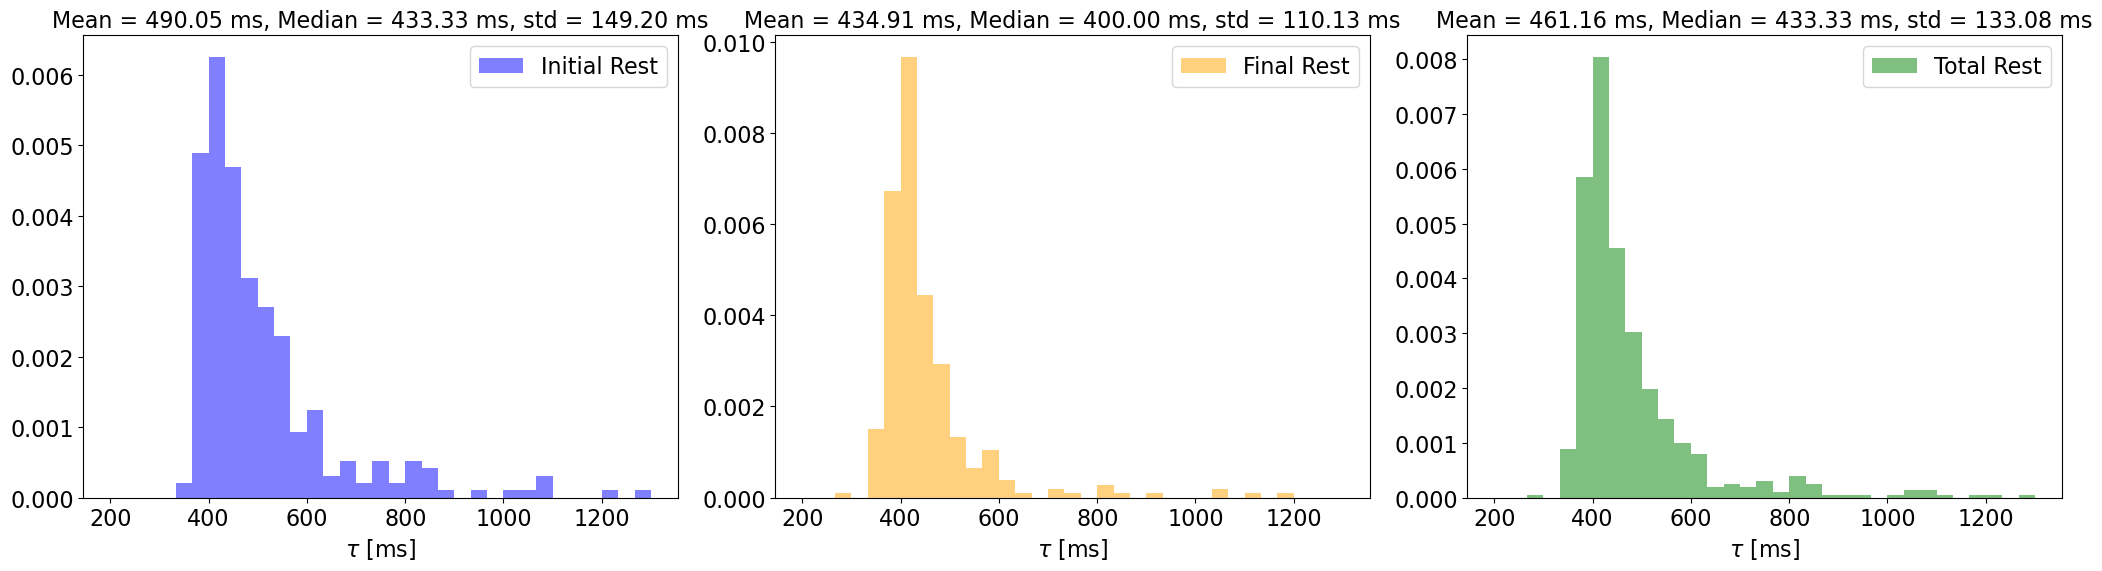

In [164]:
fig, ax = plt.subplots(1,3, figsize = (21,6))

ax[0].hist(tau_in, bins = bin_edges, color = 'blue', density = True, alpha = 0.5, label = 'Initial Rest')
ax[1].hist(tau_end, bins = bin_edges, color = 'orange', density = True, alpha = 0.5,  label = 'Final Rest')
ax[2].hist(tau_rest, bins = bin_edges, color = 'green', density = True, alpha = 0.5, label = 'Total Rest')

ax[0].set_title(r'Mean = {:.2f} ms, Median = {:.2f} ms, std = {:.2f} ms'.format(mean_in, median_in, std_in))
ax[1].set_title(r'Mean = {:.2f} ms, Median = {:.2f} ms, std = {:.2f} ms'.format(mean_end, median_end, std_end))
ax[2].set_title(r'Mean = {:.2f} ms, Median = {:.2f} ms, std = {:.2f} ms'.format(mean_rest, median_rest, std_rest))

ax[0].set_xlabel(r'$\tau$ [ms]')
ax[1].set_xlabel(r'$\tau$ [ms]')
ax[2].set_xlabel(r'$\tau$ [ms]')

ax[0].legend()
ax[1].legend()
ax[2].legend()

plt.savefig('results/autocorrelation_times/act_rest_histograms.png')

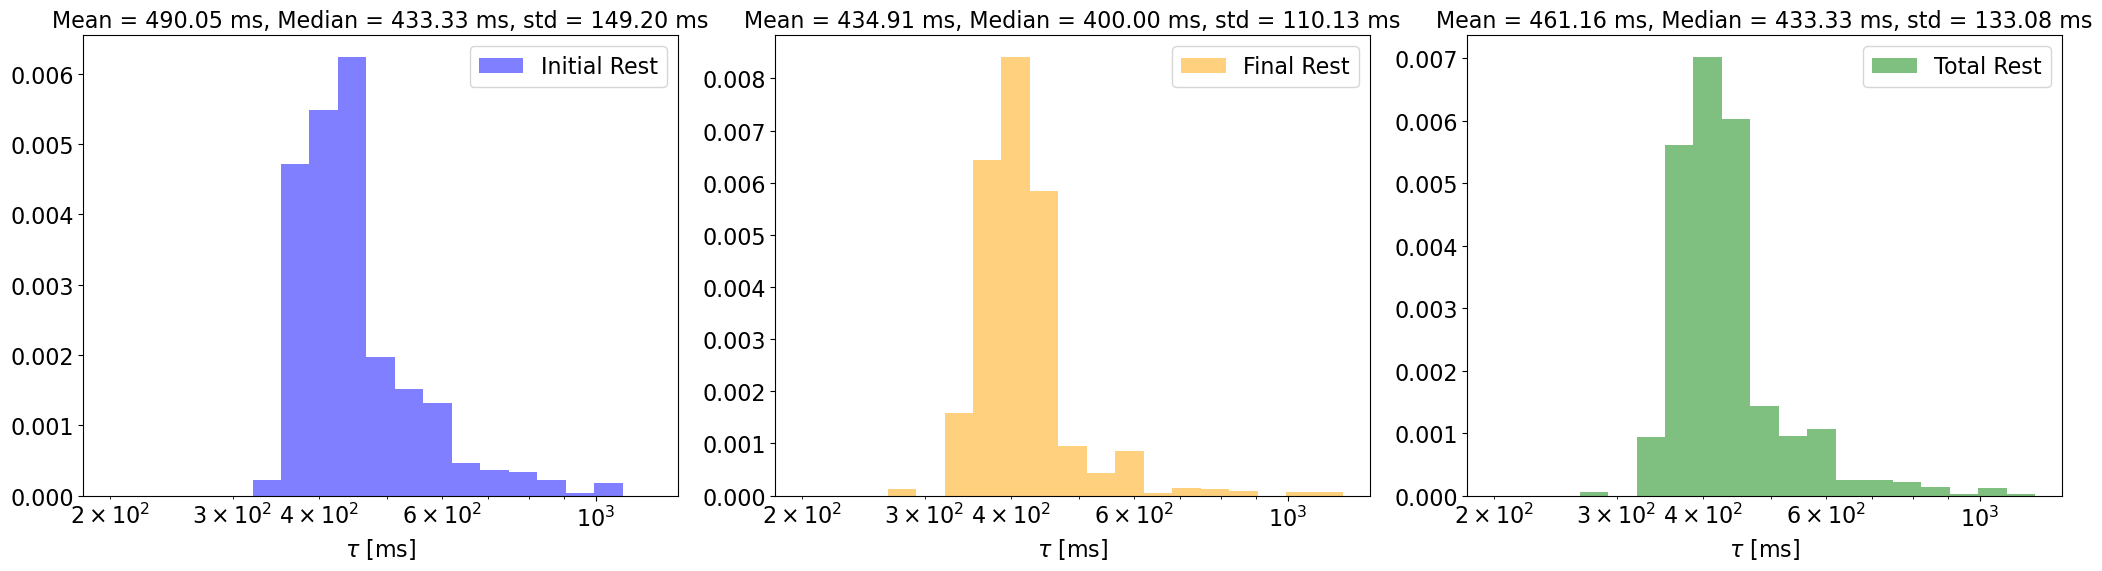

In [165]:
#logarithmic binning
log_bin_edges = np.logspace(np.log10(200), np.log10(1200), 20)

fig, ax = plt.subplots(1,3, figsize = (21,6))

ax[0].hist(tau_in, bins = log_bin_edges, color = 'blue', density = True, alpha = 0.5, label = 'Initial Rest')
ax[1].hist(tau_end, bins = log_bin_edges, color = 'orange', density = True, alpha = 0.5,  label = 'Final Rest')
ax[2].hist(tau_rest, bins = log_bin_edges, color = 'green', density = True, alpha = 0.5, label = 'Total Rest')

ax[0].set_title(r'Mean = {:.2f} ms, Median = {:.2f} ms, std = {:.2f} ms'.format(mean_in, median_in, std_in))
ax[1].set_title(r'Mean = {:.2f} ms, Median = {:.2f} ms, std = {:.2f} ms'.format(mean_end, median_end, std_end))
ax[2].set_title(r'Mean = {:.2f} ms, Median = {:.2f} ms, std = {:.2f} ms'.format(mean_rest, median_rest, std_rest))

ax[0].set_xlabel(r'$\tau$ [ms]')
ax[1].set_xlabel(r'$\tau$ [ms]')
ax[2].set_xlabel(r'$\tau$ [ms]')

ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[2].set_xscale('log')

ax[0].legend()
ax[1].legend()
ax[2].legend()

plt.savefig('results/autocorrelation_times/act_rest_histograms_logscale.png')

#### Plot of rest-autocorrelation time

In [166]:
bin_edges = np.linspace(Min, Max, 25)

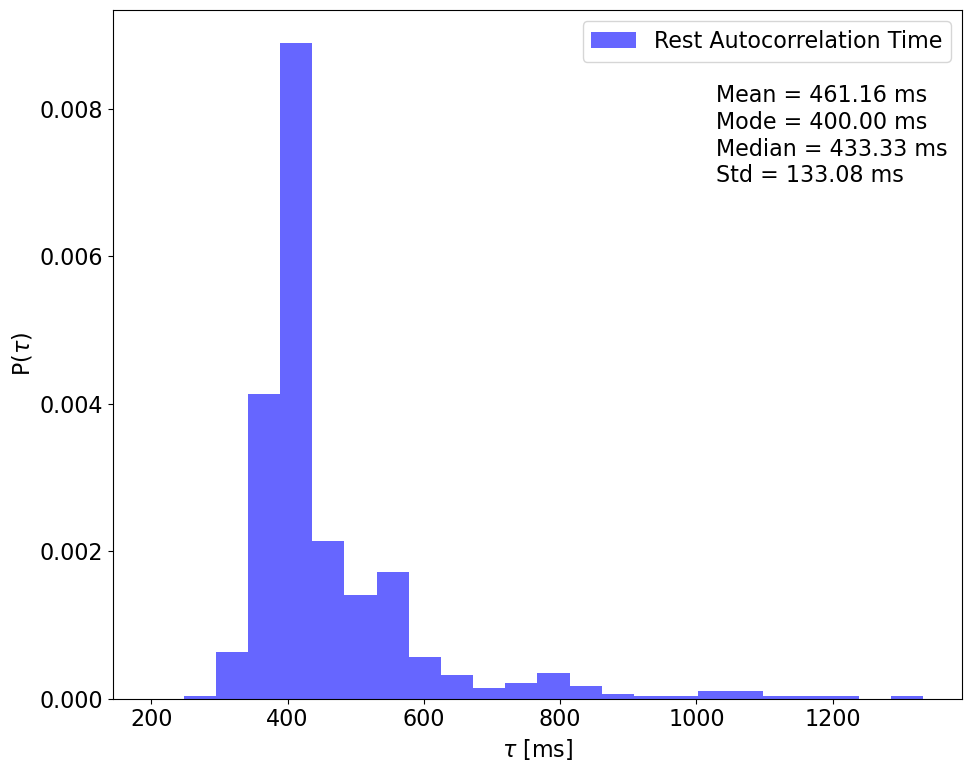

In [174]:
plt.figure(figsize=(10,8))
plt.hist(tau_rest, bins = bin_edges, color = 'blue', density = True, alpha = 0.6, label = 'Rest Autocorrelation Time')
plt.text(0.71, 0.75, 'Mean = {:.2f} ms\nMode = {:.2f} ms\nMedian = {:.2f} ms\nStd = {:.2f} ms'.format(mean_rest, mode_rest, median_rest, std_rest), transform=plt.gca().transAxes)
plt.xlabel(r'$\tau$ [ms]')
plt.ylabel(r'P($\tau$)')
plt.legend()
plt.savefig('results/autocorrelation_times/act_rest_histogram.png')

### Autocorrelation times with stimulus

In [175]:
#hyperparameter
n_lag = stimuli_window

#n_lag=1000

In [176]:
#computing autocorrelation times
taus = []

for n in range(n_traces):

    for i in range(N_stimuli):

        #selecting the trace
        trace = traces[n, stimuli_periods[i]]

        # autocorrelation times
        C = sm.tsa.acf(trace, nlags= n_lag)
        taus.append(HWHM(C)*dt) 

In [177]:
#saving the data
taus = np.array(taus)
np.save('results/autocorrelation_times/act_stimuli', taus)

### Histogramming the autocorrelation times for stimuli periods

In [195]:
#loading the data
tau_stim = np.load('results/autocorrelation_times/act_stimuli.npy')

In [196]:
#hyperparameters
Min = 6*dt
Max = 300*dt
bin_edges = np.arange(6, 100 )*3*dt
log_bin_edges = np.logspace(np.log10(Min), np.log10(Max), 20)

print('Min:', Min, '[ms]\t', 'Max:', Max, '[ms]')

Min: 200.0 [ms]	 Max: 10000.0 [ms]


In [197]:
#cleaning the data
tau_stim = tau_stim[tau_stim>Min]
tau_stim = tau_stim[tau_stim<Max]

In [198]:
#statistics
mean_stim = np.mean(tau_stim)
mode_stim = mode_calculator(tau_stim)
median_stim = np.median(tau_stim)
std_stim = np.std(tau_stim)

In [199]:
print('Mean tau stim:', mean_stim, '[ms]\t', 'Mode tau stim:', mode_stim, '[ms]\t', 'Median tau stim:', median_stim, '[ms]\t', 'Standard deviation tau stim:', std_stim, '[ms]')

Mean tau stim: 3234.149985061249 [ms]	 Mode tau stim: 384.5029239766082 [ms]	 Median tau stim: 2633.3333333333335 [ms]	 Standard deviation tau stim: 2084.6719922694406 [ms]


In [200]:
#bin_edges for hisstogramming
bin_edges = np.arange(0, 70)*4*dt*10**(-3)

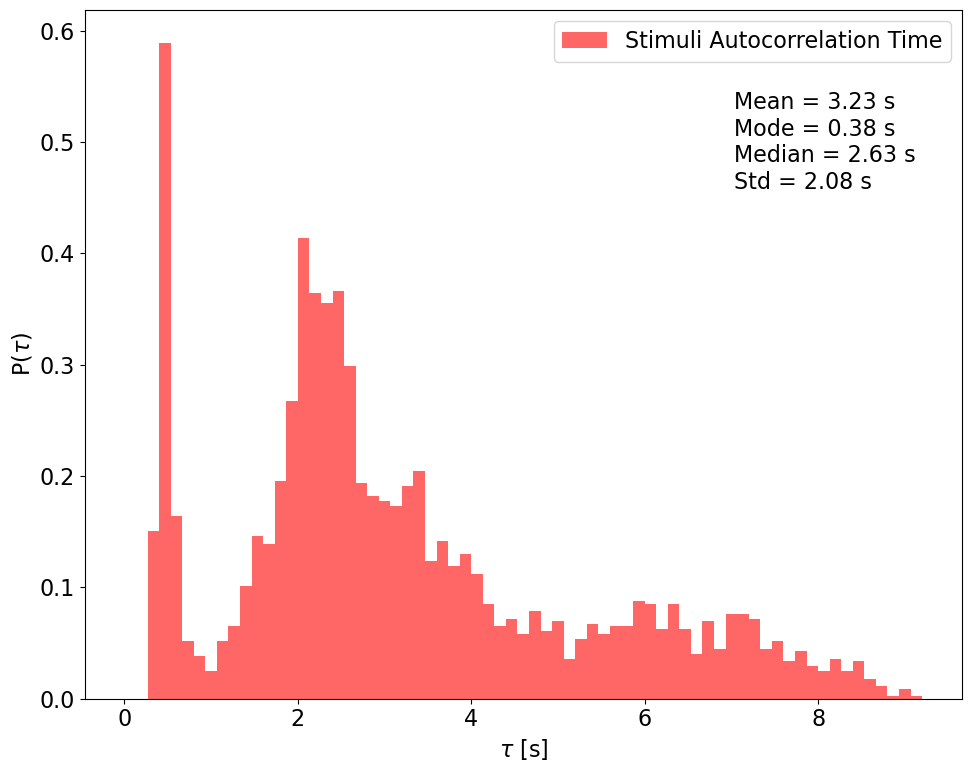

In [205]:
plt.figure(figsize=(10,8))
plt.hist(tau_stim*10**(-3), bins = bin_edges, color = 'red', density = True, alpha = 0.6, label = 'Stimuli Autocorrelation Time')
plt.text(0.74, 0.74, 'Mean = {:.2f} s\nMode = {:.2f} s\nMedian = {:.2f} s\nStd = {:.2f} s'.format(mean_stim*10**(-3), mode_stim*10**(-3), median_stim*10**(-3), std_stim*10**(-3)), transform=plt.gca().transAxes)
plt.xlabel(r'$\tau$ [s]')
plt.ylabel(r'P($\tau$)')
plt.legend()
plt.savefig('results/autocorrelation_times/act_stimuli_histogram.png')

In [207]:
bin_edges = np.linspace(Min, Max, 25)

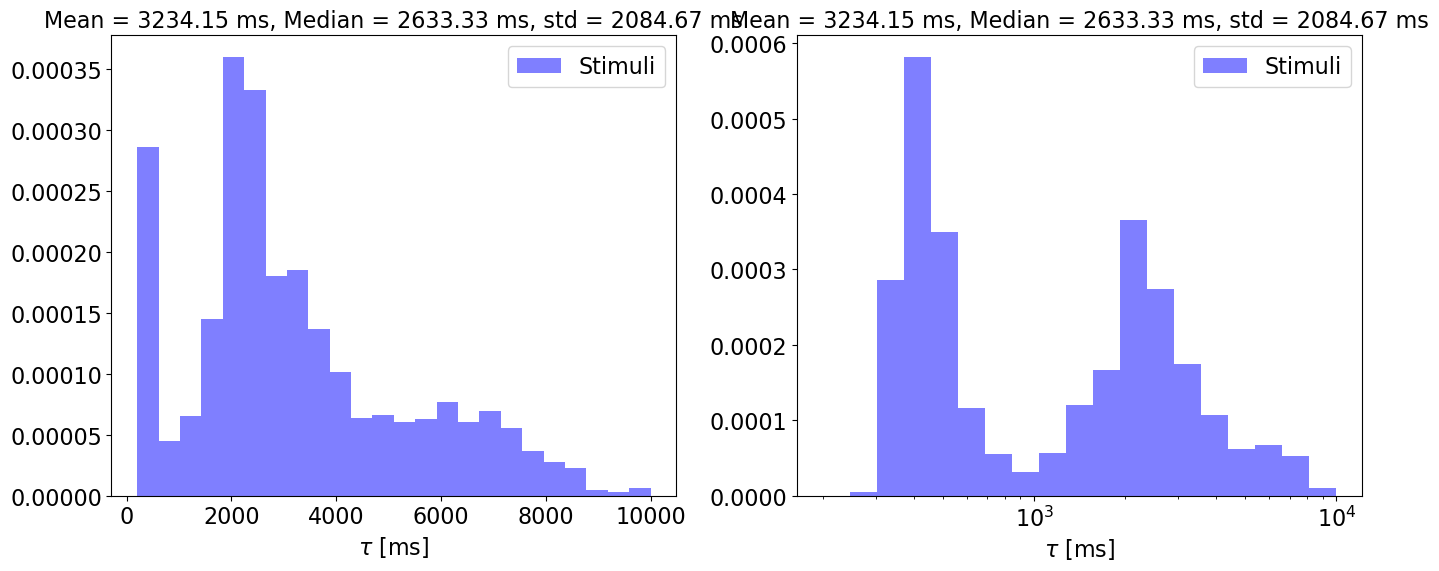

In [208]:
#histogram
fig, ax = plt.subplots(1,2, figsize = (14,6))

ax[0].hist(tau_stim, bins = bin_edges, color = 'blue', density = True, alpha = 0.5, label = 'Stimuli')
ax[1].hist(tau_stim, bins = log_bin_edges, color = 'blue', density = True, alpha = 0.5, label = 'Stimuli')

ax[0].set_title(r'Mean = {:.2f} ms, Median = {:.2f} ms, std = {:.2f} ms'.format(mean_stim, median_stim, std_stim))
ax[1].set_title(r'Mean = {:.2f} ms, Median = {:.2f} ms, std = {:.2f} ms'.format(mean_stim, median_stim, std_stim))


ax[0].set_xlabel(r'$\tau$ [ms]')
ax[1].set_xlabel(r'$\tau$ [ms]')
ax[0].legend()
ax[1].legend()
ax[1].set_xscale('log')

plt.savefig('results/autocorrelation_times/act_stimuli_histograms.png')

## Comparison between autocorrelation times and charecteristic times of simuli

#### Stimuli analysis: exponential fit and autocorrelation times

In [209]:
aut_times = []
lag_times = []
asc_times = []
t_half1_times = []
t_half2_times = []
rest_times = []

for n in range(n_traces):

    #selecting the trace
    trace_complete = traces[n, :]
    #selecting the stimuli
    stimuli = stimuli_idx[n, :]
    #computing the intervals
    initial_rest, final_rest, stimuli_periods, complete_stimuli_interval, complete_interval = periods_intervalls(stimuli, stimuli_window)

    #computing the tau_rest
    C = sm.tsa.acf(trace_complete[initial_rest], nlags= 1000)
    t_rest = HWHM(C)

    for i in range(N_stimuli):
        rest_times.append(t_rest)
        trace = trace_complete[stimuli_periods[i]]

        #fitting times
        [t_asc, t_half1, t_half2, a1, b1, a2, b2, lag, c] = exponential_decay_fit(trace)

        #autocorrelation time
        C = sm.tsa.acf(trace, nlags= len(trace)-1)

        aut_times.append(HWHM(C))
        lag_times.append(lag)
        asc_times.append(t_asc)
        t_half1_times.append(t_half1)
        t_half2_times.append(t_half2)

/home/zenn/anaconda3/envs/VCS/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/tmp/ipykernel_14056/1333809963.py:5: RuntimeWarning: overflow encountered in exp
  return np.abs(a1) * np.exp(-b1 * x) + c + np.abs(a2)*np.exp(-b2*np.abs((x-lag)))


In [210]:
#save data
np.savez('results/characteristic_times/characteristic_times', aut_times = aut_times, lag_times = lag_times, asc_times = asc_times, t_half1_times = t_half1_times, t_half2_times = t_half2_times, rest_times = rest_times)

In [211]:
#load data
data = np.load('results/characteristic_times/characteristic_times.npz', allow_pickle=True)
aut_times = data['aut_times']
lag_times = data['lag_times']
asc_times = data['asc_times']
t_half1_times = data['t_half1_times']
t_half2_times = data['t_half2_times']
rest_times = data['rest_times'] 

#### Cleaning the data

In [212]:
### masks over t_half
mask1 = t_half1_times != None

t_half1_times = t_half1_times[mask1].astype(float)
t_half2_times = t_half2_times[mask1].astype(float)
aut_times = aut_times[mask1].astype(float)
lag_times = lag_times[mask1].astype(float)#load data
asc_times = asc_times[mask1].astype(float)
rest_times = rest_times[mask1].astype(float)

t_half1_times = t_half1_times*dt
t_half2_times = t_half2_times*dt
aut_times = aut_times*dt
lag_times = lag_times*dt
asc_times = asc_times*dt

Min = 0*10**3
Max = 20*10**3

mask2 = t_half1_times>Min

t_half1_times = t_half1_times[mask2]
t_half2_times = t_half2_times[mask2]
aut_times = aut_times[mask2]
lag_times = lag_times[mask2]
asc_times = asc_times[mask2]
rest_times = rest_times[mask2]

mask3 = t_half1_times<Max

t_half1_times = t_half1_times[mask3]
t_half2_times = t_half2_times[mask3]
aut_times = aut_times[mask3]
lag_times = lag_times[mask3]
asc_times = asc_times[mask3]
rest_times = rest_times[mask3]

mask4 = t_half2_times>Min

t_half1_times = t_half1_times[mask4]
t_half2_times = t_half2_times[mask4]
aut_times = aut_times[mask4]
lag_times = lag_times[mask4]
asc_times = asc_times[mask4]
rest_times = rest_times[mask4]

mask5 = t_half2_times<Max

t_half1_times = t_half1_times[mask5]
t_half2_times = t_half2_times[mask5]
aut_times = aut_times[mask5]
lag_times = lag_times[mask5]
asc_times = asc_times[mask5]
rest_times = rest_times[mask5]

#masks over t_lag
Min = 0
Max = 60*10**3

mask6 = lag_times>Min

t_half1_times = t_half1_times[mask6]
t_half2_times = t_half2_times[mask6]
aut_times = aut_times[mask6]
lag_times = lag_times[mask6]
asc_times = asc_times[mask6]
rest_times = rest_times[mask6]

mask7 = lag_times<Max

t_half1_times = t_half1_times[mask7]
t_half2_times = t_half2_times[mask7]
aut_times = aut_times[mask7]
lag_times = lag_times[mask7]
asc_times = asc_times[mask7]
rest_times = rest_times[mask7]

#masks over t_asc
Min = 0
Max = 20*10**3

mask8 = asc_times>Min

t_half1_times = t_half1_times[mask8]
t_half2_times = t_half2_times[mask8]
aut_times = aut_times[mask8]
lag_times = lag_times[mask8]
asc_times = asc_times[mask8]
rest_times = rest_times[mask8]

mask9 = asc_times<Max

t_half1_times = t_half1_times[mask9]
t_half2_times = t_half2_times[mask9]
aut_times = aut_times[mask9]
lag_times = lag_times[mask9]
asc_times = asc_times[mask9]
rest_times = rest_times[mask9]


#masks over autocorrelation times
Min = 0

mask10 = aut_times>Min

t_half1_times = t_half1_times[mask10]
t_half2_times = t_half2_times[mask10]
aut_times = aut_times[mask10]
lag_times = lag_times[mask10]
asc_times = asc_times[mask10]
rest_times = rest_times[mask10]

#mask over rest times
Min = 0

mask11 = rest_times>Min

t_half1_times = t_half1_times[mask11]
t_half2_times = t_half2_times[mask11]
aut_times = aut_times[mask11]
lag_times = lag_times[mask11]
asc_times = asc_times[mask11]
rest_times = rest_times[mask11]

In [213]:
aut_times = aut_times*10**(-3)
lag_times = lag_times*10**(-3)
asc_times = asc_times*10**(-3)
rest_times = rest_times*10**(-3)
t_half1_times = t_half1_times*10**(-3)
t_half2_times = t_half2_times*10**(-3)

#### Constructing the distribution

In [214]:
tau_rest = tau_rest*10**(-3)

In [215]:
dist = np.concatenate([tau_rest[:200], asc_times*(1-np.log(2))+t_half1_times, t_half2_times])

#assuming second exponential is uncorrelate to first one (lag>>tau)
#dist of rest autocorrelation times
#asc time + t_half1 

In [216]:
#bin_edges for hisstogramming
bin_edges = np.arange(0, 70)*4*dt*10**(-3)

#histogramming the data
counts, _ = np.histogram(dist, bins = bin_edges, density=True)
bin_centers = 0.5*(_[1:] + _[:-1])

In [217]:
first_peak = tau_rest
second_peak = asc_times*(1-np.log(2))+t_half1_times
tail = (1-np.log(2))*(1-np.log(2))*lag_times+t_half2_times

In [218]:
counts_fp, _ = np.histogram(first_peak, bins = bin_edges, density=True)
counts_sp, _ = np.histogram(second_peak, bins = bin_edges, density=True)
counts_t, _ = np.histogram(tail, bins = bin_edges, density=True)

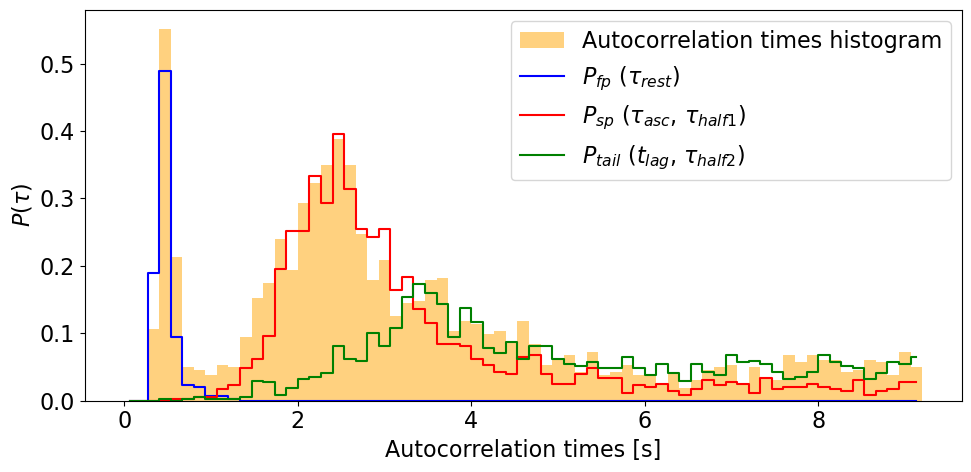

In [221]:
fig = plt.figure(figsize=(10,5))

plt.hist(aut_times, bins = bin_edges, density = True, color = 'orange', alpha = 0.5, label = 'Autocorrelation times histogram')
#plt.step(bin_centers, counts, where='mid', color = 'red', label = 'Constructed distribution')
plt.step(bin_centers, counts_fp/9, where='mid', color = 'blue', label = r'$P_{fp}$ ($\tau_{rest}$)')
plt.step(bin_centers, counts_sp/1.5, where='mid', color = 'red', label = r'$P_{sp}$ ($\tau_{asc}$, $\tau_{half1}$)')
plt.step(bin_centers, counts_t/2, where='mid', color = 'green', label = r'$P_{tail}$ ($t_{lag}$, $\tau_{half2}$)')
plt.legend()
plt.xlabel('Autocorrelation times [s]')
plt.ylabel(r'$P(\tau)$')

plt.savefig('results/characteristic_times/autocorrelation_times_distribution.png')

Text(0, 0.5, 'Rest times [ms]')

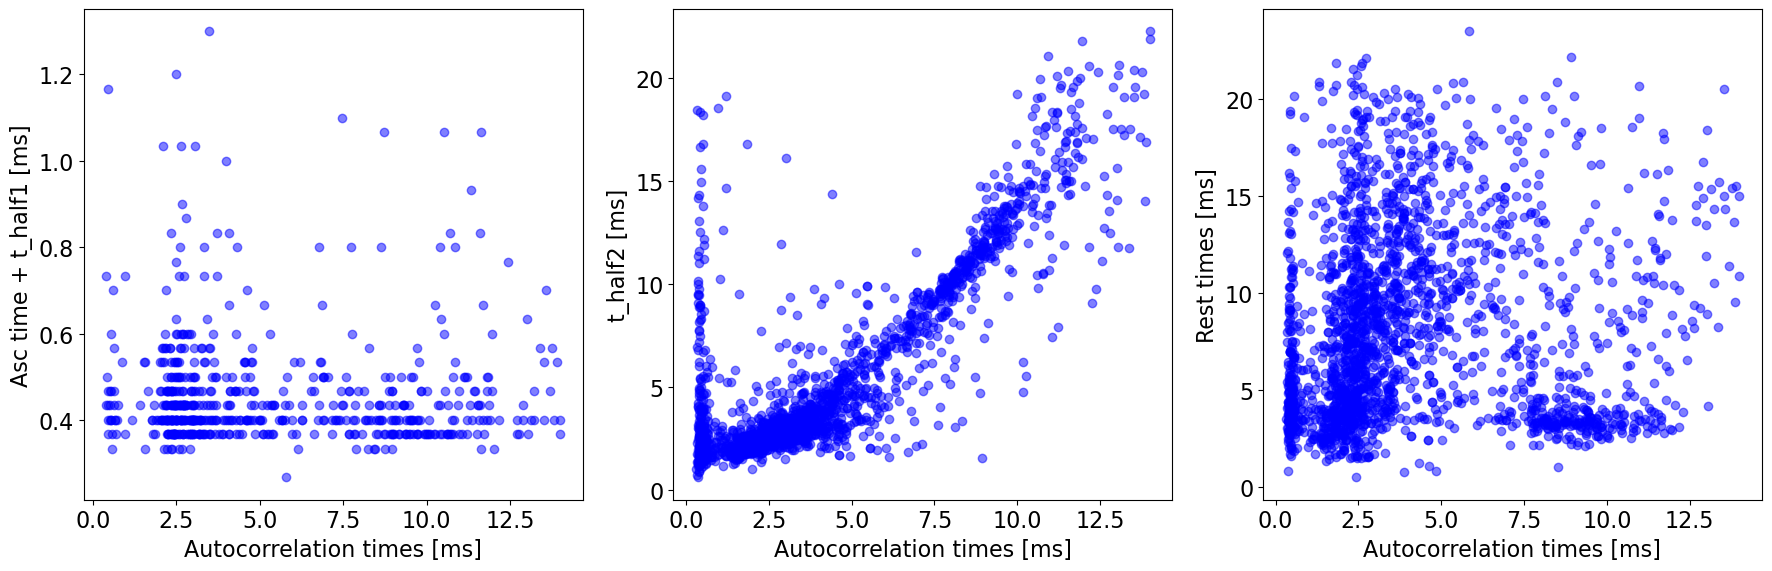

In [222]:
fig, ax = plt.subplots(1,3, figsize=(18,6))

ax[0].scatter(aut_times[:len(first_peak)],  first_peak, color = 'blue', alpha = 0.5)
ax[0].set_ylabel('Asc time + t_half1 [ms]')
ax[0].set_xlabel('Autocorrelation times [ms]')

ax[1].scatter(aut_times, second_peak, color = 'blue', alpha = 0.5)
ax[1].set_xlabel('Autocorrelation times [ms]')
ax[1].set_ylabel('t_half2 [ms]')

ax[2].scatter(aut_times, tail, color = 'blue', alpha = 0.5)
ax[2].set_xlabel('Autocorrelation times [ms]')
ax[2].set_ylabel('Rest times [ms]')

## Power spectrum

In [223]:
N_timestpes = 45_000  #for the filtered and smoothed traces
df = 1/dt

print('Minimum discretized step:', df)
print('dt*df =', dt*df)

Minimum discretized step: 0.03
dt*df = 1.0


### Raw-data without smoothing

In [224]:
top_percentage = 0.6
path_to_traces = 'data/top{}_traces/'.format(top_percentage)
print(path_to_traces)

files = os.listdir(path_to_traces)
print('Number of files:', len(files))

data/top0.6_traces/
Number of files: 8


In [225]:
lag_mode = mode_calculator(lag_times)

In [226]:
p = 0.01

In [229]:
avg_P = np.zeros(15_001)
avg_w = np.zeros(15_001)

counter = 0

for file in files:
    data = np.load(path_to_traces+file)
    traces = data['traces']

    for n in range(traces.shape[0]):

        counter = counter + 1

        trace = traces[n, :]
        
        omega, psd = welch(trace, fs = f_sam, nperseg = 30000)

        avg_P = avg_P + psd
        avg_w = avg_w + omega

        if np.random.random()<p:
            plt.figure(figsize=(15,5))
            plt.plot(omega, psd, color = 'blue')
            plt.xscale('log')
            plt.savefig('results/power_spectrum/examples_of_power_spectrum/psd_trace{}_file{}'.format(n, file.split('.npz'[0])))
            plt.close()

avg_P = avg_P/counter
avg_w = avg_w/counter

In [230]:
P_traces = avg_P
w_traces = avg_w

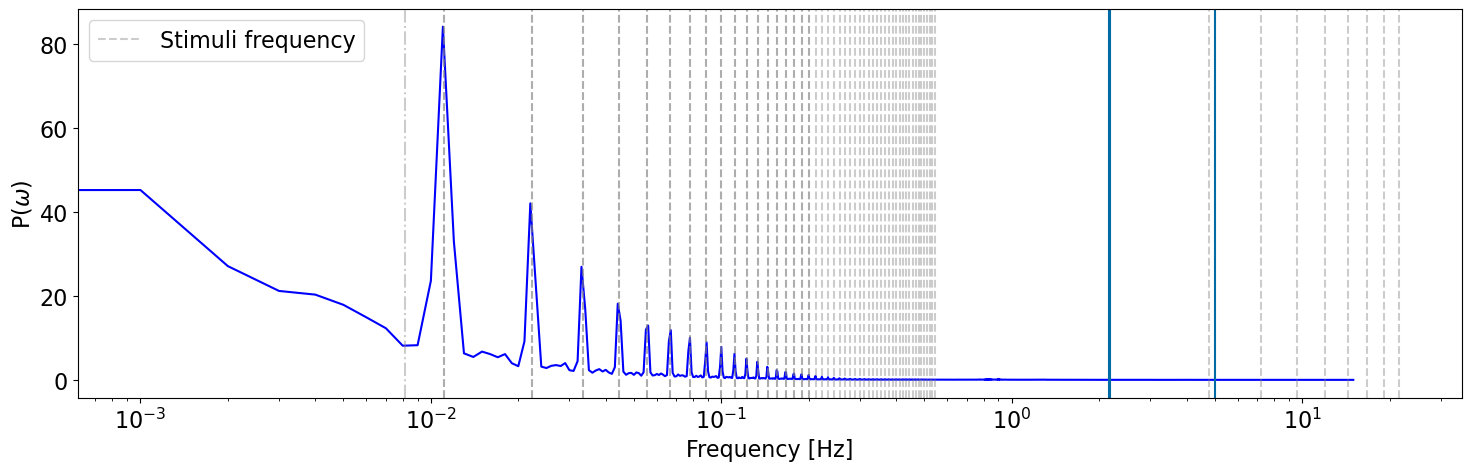

In [231]:
plt.figure(figsize=(15,5))

#Power spectrum
plt.plot(avg_w, avg_P, color = 'blue')


plt.axvline(1/(90), color = 'gray', linestyle = '--', alpha = 0.4, label = 'Stimuli frequency')

for i in range(2, 50):
    plt.axvline(i/(90), color = 'gray', linestyle = '--', alpha = 0.4)

plt.axvline(1/tau_rest.mean())

plt.axvline(1/tau_rest[tau_rest<1.2].mean())

plt.axvline(1/0.2)

for i in range(2, 10):
    plt.axvline(i/mode_calculator(tau_rest), color = 'gray', linestyle = '--', alpha = 0.4)

plt.xlabel('Frequency [Hz]')
plt.ylabel(r'P($\omega$)')
plt.legend()
plt.xscale('log')
#plt.yscale('log')

plt.axvline(1/(90), color = 'gray', linestyle = '--', alpha = 0.4, label = 'Stimuli frequency')
plt.axvline(1/(90+lag_mode), color = 'gray', linestyle = '-.', alpha = 0.4, label = 'Second exponential frequency')
#plt.axvline(1/(90+t_half1_times.mean()*10**(-3)+(mode_calculator(asc_times*(1-np.log(2))+t_half1_times))*10**(-3)), color = 'gray', linestyle = ':', alpha = 0.4, label = 'Expected frequency')


for i in range(2, 19):
    plt.axvline(i/(90), color = 'gray', linestyle = '--', alpha = 0.4)



plt.savefig('results/power_spectrum/average_power_spectrum_all_traces.png')

### Filtered data with smoothing

In [232]:
# path to pre-process data
path_to_final_data = 'data/cleaned_traces/cleaned_traces_top0.6_gaussian_filter_sigma6.npy'

#loading the cleaned traces
traces = np.load(path_to_final_data)

#loading the corresponding stimuli
stimuli_idx = np.load('data/cleaned_traces/stimuli_idx_top0.6_gaussian_filter_sigma6.npy')

#useful for loops
n_traces = traces.shape[0]
length = traces.shape[1]
N_stimuli = 10

In [233]:
#Computing the average spectral density
avg_P = np.zeros(length//2 +1)
avg_w = np.zeros(length//2 +1)

for n in range(n_traces):
    trace = np.nan_to_num(traces[n, :],0)
    
    omega, psd = welch(trace, fs = 30, noverlap=1, nperseg = length)    
    avg_P = avg_P + psd
    avg_w = omega + avg_w

avg_P = avg_P/n_traces
avg_w = avg_w/n_traces

In [234]:
#Plot of Power spectrum
plt.figure(figsize=(15,5))

#Power spectrum
plt.plot(avg_w, avg_P, color = 'blue')

plt.axvline(1/(90), color = 'gray', linestyle = '--', alpha = 0.4, label = 'Stimuli frequency')

for i in range(2, 50):
    plt.axvline(i/(90), color = 'gray', linestyle = '--', alpha = 0.4)

plt.axvline(1/tau_rest.mean())

plt.axvline(1/tau_rest[tau_rest<1.2].mean())

for i in range(2, 10):
    plt.axvline(i/mode_calculator(tau_rest), color = 'gray', linestyle = '--', alpha = 0.4)

plt.xlabel('Frequency [Hz]')
plt.ylabel(r'P($\omega$)')
plt.legend()
plt.xscale('log')
#plt.yscale('log')

plt.savefig('results/power_spectrum/average_power_spectrum_cleaned_traces.png')

In [235]:
P_smooth = avg_P
w_smooth = avg_w

In [236]:
f_stim = 1/90
f_stim_asc = 1/(90+3.06)
f_lag = 1/(90+30)

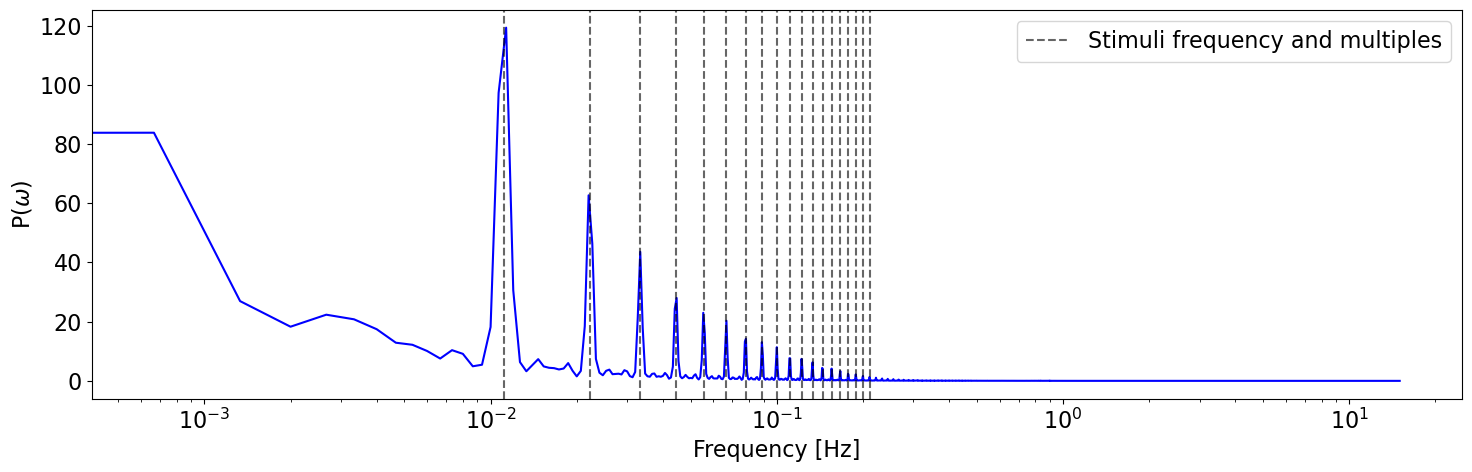

In [240]:
plt.figure(figsize=(15,5))

plt.plot(w_smooth, P_smooth, color = 'blue')

plt.xscale('log')


plt.axvline(f_stim, label = 'Stimuli frequency and multiples', color = 'black', linestyle = '--', alpha = 0.6)  
#plt.axvline(f_stim_asc)


for i in range(2, 20):
    plt.axvline(i*f_stim, color = 'black', linestyle = '--', alpha = 0.6)
    #
#plt.axvline(f_sam, label = 'Sampling frequency')
#plt.axvline(f_smooth, label = 'Smoothing frequency')
#for i in range(2, 10):
#    plt.axvline(i*f_smooth)

#plt.axvline(f_rest, label = 'Rest frequency')

plt.legend()
plt.xlabel('Frequency [Hz]')
plt.ylabel(r'P($\omega$)')

plt.savefig('results/power_spectrum/power_spectrum.png')